In [1]:
if 'already_executed' not in globals():
    already_executed = False

if not already_executed:
    import os
    os.chdir("../")
    %load_ext autoreload
    %autoreload 2
    already_executed = True

In [2]:
from copy import deepcopy
import numpy as np
from typing import Optional
from sklearn.preprocessing import StandardScaler
from src.pricers.abstract_pricer import PricerAbstract
from src.samplers.abstract_sampler import SamplerAbstract


import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
from src.samplers.geometric_brownian_motion_put_sampler import GeometricBrownianMotionPutSampler
sampler = GeometricBrownianMotionPutSampler(**{
    "asset0": 100.0,
    "sigma": 0.2,
    "r": 0.05,
    "strike": 100.0,
    "t": 1.0,
    "cnt_times": 60,
    "seed": None, 
    "cnt_trajectories": 1_000_000
})

# LSPI

In [4]:
from dataclasses import dataclass
@dataclass 
class A:
    _: int

self = A(0)

def _create_features(self, markov_state: np.ndarray, time_grid: np.ndarray) -> np.ndarray:
    n_paths, n_times, state_dim = markov_state.shape
    T = time_grid[-1]
    
    # Нормализованное время до экспирации
    time_to_exp = (T - time_grid) / T
    time_to_exp = np.tile(time_to_exp, (n_paths, 1))[..., None]
    
    # Объединяем время и состояние
    features = np.concatenate([time_to_exp, markov_state], axis=-1)
    flat_features = features.reshape(-1, features.shape[-1])
    
    # Первый вызов - инициализируем и фитим трансформеры
    if not self.is_fitted_:
        self.scaler_ = StandardScaler()
        self.poly_ = PolynomialFeatures(degree=self.degree, include_bias=True)
        
        scaled = self.scaler_.fit_transform(flat_features)
        poly_features = self.poly_.fit_transform(scaled)
        self.n_features_ = poly_features.shape[1]
        self.is_fitted_ = True
    else:
        # Используем обученные трансформеры
        scaled = self.scaler_.transform(flat_features)
        poly_features = self.poly_.transform(scaled)
    
    return poly_features.reshape(n_paths, n_times, -1)

def _create_features(self, markov_state: np.ndarray, time_grid: np.ndarray) -> np.ndarray:
    M = markov_state[:, :, 0] / 100.
    exp_term = np.exp(-M / 2.0)
    T = self.sampler.time_grid[-1]
    t = time_grid

    phi = np.zeros((*markov_state[:, :, 0].shape, 7), dtype = float)
    phi[:, :, 0] = 1.0
    phi[:, :, 1] = exp_term
    phi[:, :, 2] = exp_term * (1.0 - M)
    phi[:, :, 3] = exp_term * (1.0 - 2.0 * M + 0.5 * M * M)
    phi[:, :, 4] = np.sin(np.pi * (T - t) / (2.0 * T))
    phi[:, :, 5] = np.log(np.maximum(T - t, 1e-10)) # 1e-10 чтобы не было log(0)
    phi[:, :, 6] = (t / T) ** 2

    phi_reshaped = phi[:, :, 1:].reshape(-1, 6)

    if not hasattr(self, "scaler"):
        self.scaler = StandardScaler()
        self.scaler.fit(phi_reshaped)
    phi_scaled = self.scaler.transform(phi_reshaped)
    phi_scaled = phi_scaled.reshape(phi.shape[0], phi.shape[1], 6)


    phi_final = np.zeros_like(phi)
    phi_final[:, :, 0] = phi[:, :, 0]
    phi_final[:, :, 1:] = phi_scaled

    return phi_final

In [5]:
self.sampler = sampler
self.sampler.sample()

GBM sampling:   0%|          | 0/59 [00:00<?, ?it/s]

In [6]:
r = -np.log(self.sampler.discount_factor[0, 1] / self.sampler.discount_factor[0, 0]) / (self.sampler.time_deltas[0])
self.dt = sampler.time_deltas[0]
self.is_fitted_ = False
self.degree = 3
self.iterations = 100
self.tol = 1e-6
self.reg_alpha = 1e-2
quiet = False

In [7]:
# Параметры
n_paths, n_times, _ = self.sampler.markov_state.shape
gamma = np.exp(-r * self.dt)  # Коэффициент дисконтирования

# Создаем признаки
phi_all = _create_features(self,
    self.sampler.markov_state, 
    self.sampler.time_grid
)
n_features = phi_all.shape[-1]


w = np.zeros(n_features)

# Подготовка данных
phi_curr = phi_all[:, :-1, :]  # Текущие состояния (t)
phi_next = phi_all[:, 1:, :]    # Следующие состояния (t+1)
payoff_next = self.sampler.payoff[:, 1:]  # Выплаты в t+1

# Выравнивание в 1D
phi_curr_flat = phi_curr.reshape(-1, n_features)
phi_next_flat = phi_next.reshape(-1, n_features)
payoff_next_flat = payoff_next.reshape(-1)

# Флаг нетерминальных состояний
non_terminal = np.tile(
    np.arange(n_times-1, dtype=int) < n_times-2, 
    (n_paths, 1)
)
non_terminal_flat = non_terminal.reshape(-1)

# Итерации LSPI
for it in tqdm(range(self.iterations), desc="LSPI iterations"):
    prev_w = deepcopy(w)
    
    # Вычисляем Q-значения продолжения
    Q_cont_next = phi_next_flat @ w
    
    # Условие продолжения
    continue_cond = non_terminal_flat & (Q_cont_next >= payoff_next_flat)
    
    # Формируем систему уравнений
    diff_phi = phi_curr_flat - gamma * continue_cond[:, None] * phi_next_flat
    A = phi_curr_flat.T @ diff_phi
    b = gamma * phi_curr_flat.T @ ((~continue_cond) * payoff_next_flat)

    if self.reg_alpha is not None:
        A += np.eye(A.shape[0]) * self.reg_alpha
    w = np.linalg.solve(A, b)
    
    # Проверка сходимости
    diff_norm = np.linalg.norm(w - prev_w)
    if not quiet:
        print(f"Iteration {it}: ||Δw|| = {diff_norm:.9f}")
    if diff_norm < self.tol:
        if not quiet:
            print(f"Converged after {it} iterations")
        break

self.w = w

LSPI iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0: ||Δw|| = 270.964249499
Iteration 1: ||Δw|| = 807.441178147
Iteration 2: ||Δw|| = 136.796632965
Iteration 3: ||Δw|| = 95.942702207
Iteration 4: ||Δw|| = 32.482658341
Iteration 5: ||Δw|| = 11.157004461
Iteration 6: ||Δw|| = 1.222723752
Iteration 7: ||Δw|| = 0.008637418
Iteration 8: ||Δw|| = 0.000000630
Converged after 8 iterations


In [8]:
pv_payoffs = np.zeros(n_paths)
for p in range(n_paths):
    for t in range(n_times):
        # Признаки текущего состояния
        phi_t = phi_all[p, t]
        Q_cont = phi_t @ w
        payoff_t = self.sampler.payoff[p, t]
        
        # Условие исполнения
        if payoff_t >= Q_cont or t == n_times - 1:
            disc_factor = self.sampler.discount_factor[p, t]
            pv_payoffs[p] = disc_factor * payoff_t
            break
mean = pv_payoffs.mean()

# plt.figure(figsize=(10, 6))
# plt.hist(pv_payoffs)
# plt.axvline(mean)
# plt.title("Train")
# plt.grid()
# plt.show()
mean

np.float64(5.817580790897827)

In [9]:
self.sampler.sample()

GBM sampling:   0%|          | 0/59 [00:00<?, ?it/s]

In [10]:
phi_all = _create_features(self,
    self.sampler.markov_state, 
    self.sampler.time_grid
)
pv_payoffs = np.zeros(n_paths)
for p in range(n_paths):
    for t in range(n_times):
        # Признаки текущего состояния
        phi_t = phi_all[p, t]
        Q_cont = phi_t @ w
        payoff_t = self.sampler.payoff[p, t]
        
        # Условие исполнения
        if payoff_t >= Q_cont or t == n_times - 1:
            disc_factor = self.sampler.discount_factor[p, t]
            pv_payoffs[p] = disc_factor * payoff_t
            break
mean = pv_payoffs.mean()

# plt.figure(figsize=(10, 6))
# plt.hist(pv_payoffs)
# plt.axvline(mean)
# plt.title("Test")
# plt.grid()
# plt.show()
mean

np.float64(5.8242707633491735)

# LSMC

AMC price train:  98%|#########8| 58/59 [00:11<00:00,  5.36it/s]

/home/jovyan/vorobiov/AmericanOptionsPricingApproaches/src/pricers/american_monte_carlo.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


{'train': {'price': 6.075241449706711,
  'upper_bound': 11.333570641766196,
  'lower_bound': 5.568070300226569,
  'std': 7.16997808992654}}

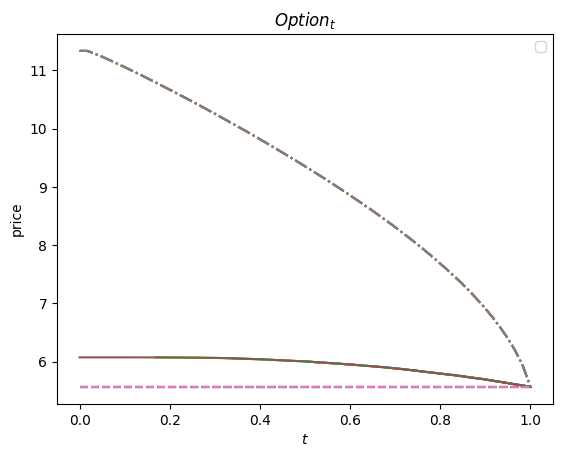

In [11]:
from src.pricers.american_monte_carlo import AmericanMonteCarloPricer
pricer = AmericanMonteCarloPricer(sampler, degree=3)
pricer.price();
pricer.result

# Exercise Boundary

  0%|          | 0/60 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------


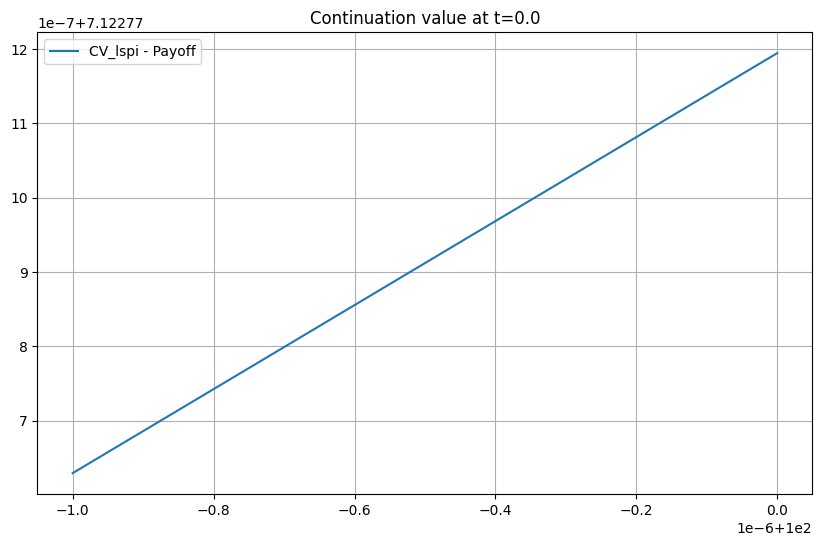

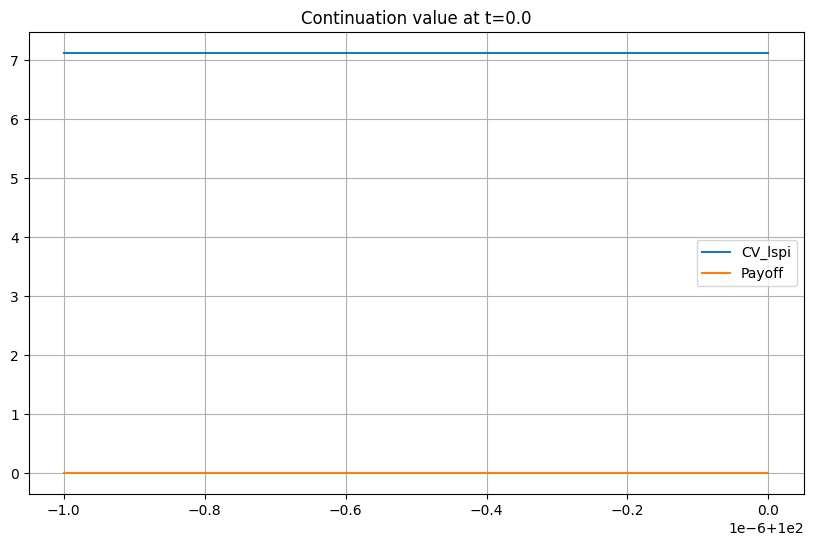

------------------------------------------------------------------------------------------------------------------------


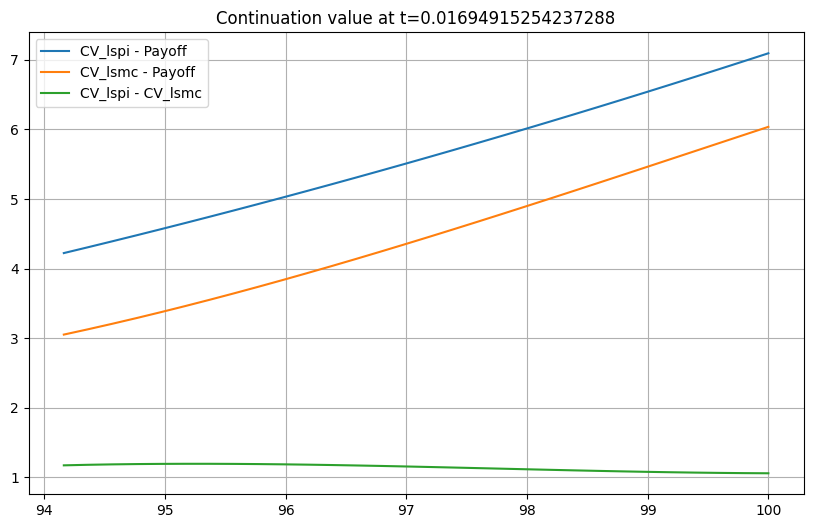

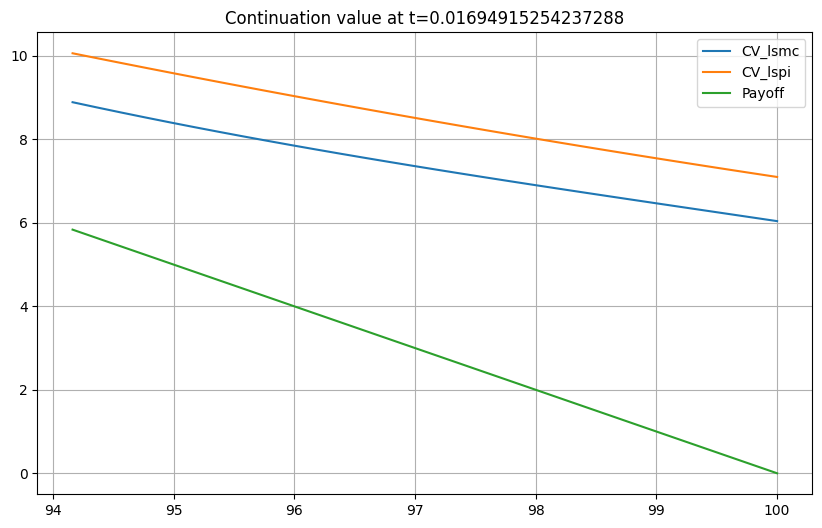

------------------------------------------------------------------------------------------------------------------------


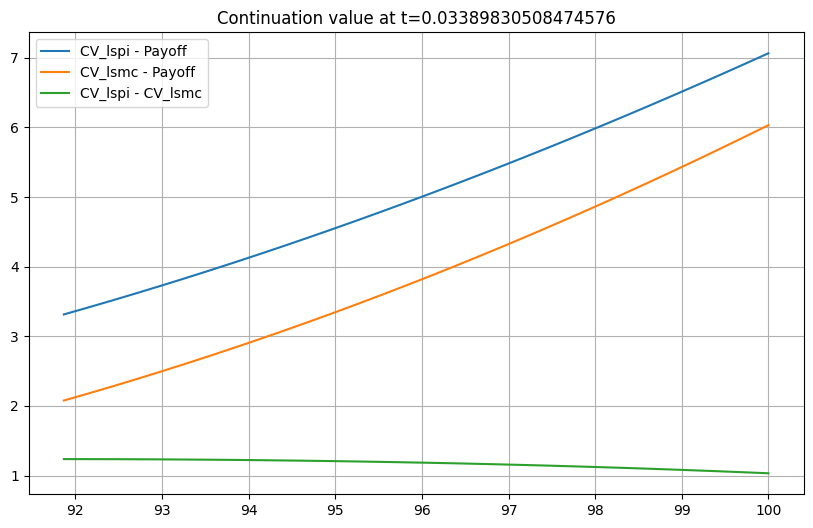

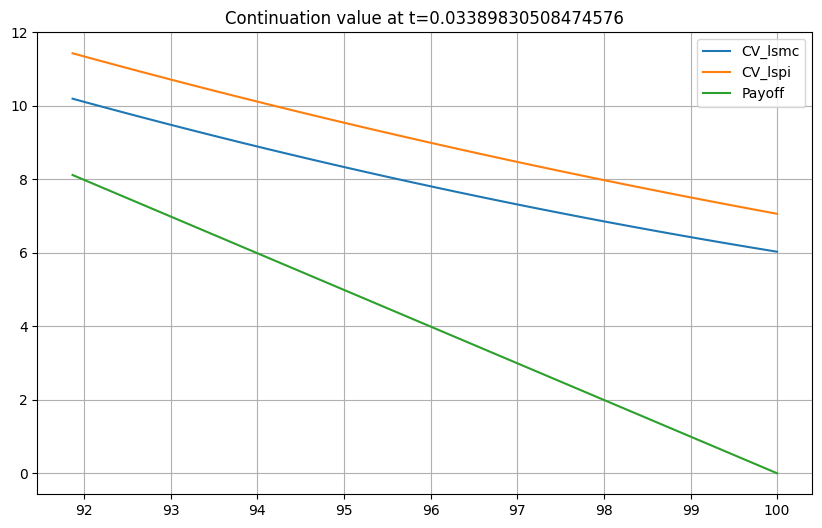

------------------------------------------------------------------------------------------------------------------------


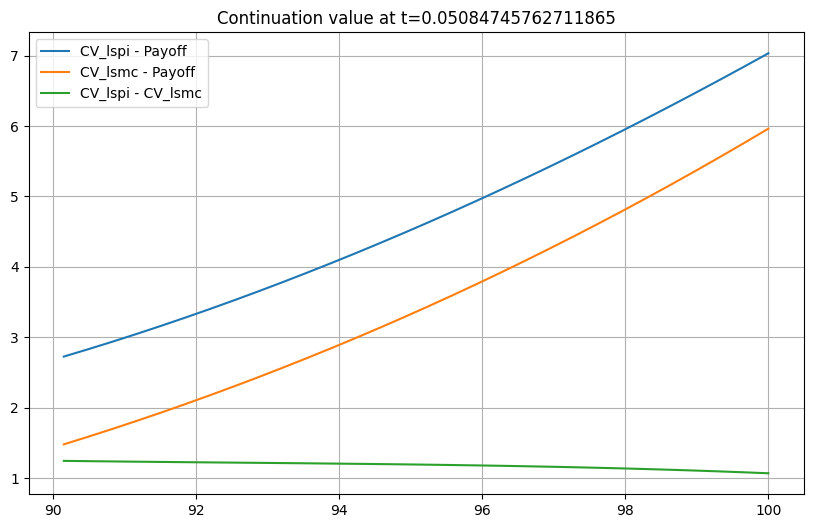

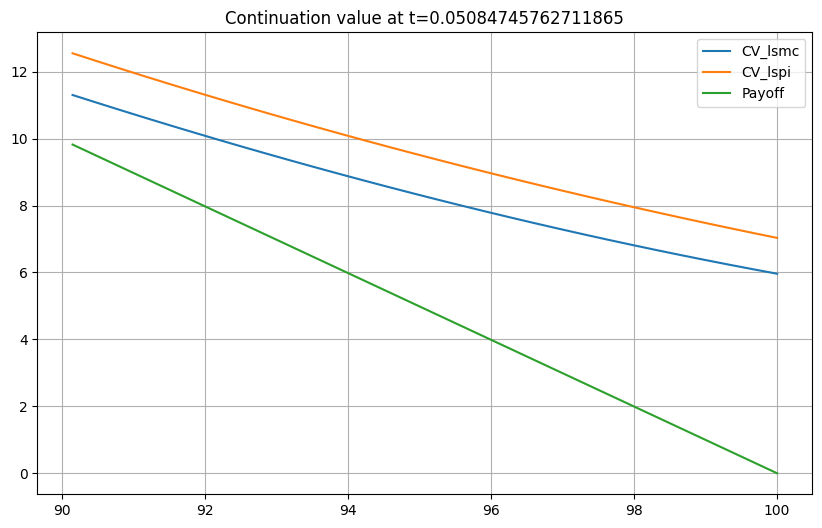

------------------------------------------------------------------------------------------------------------------------


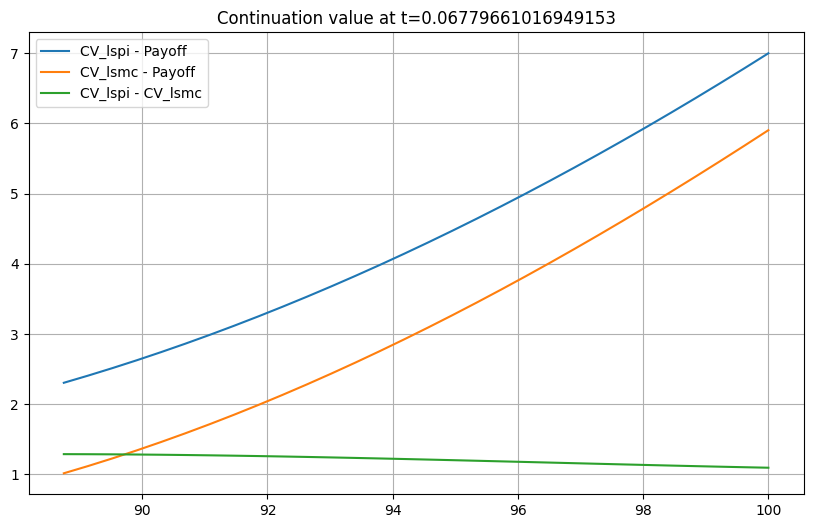

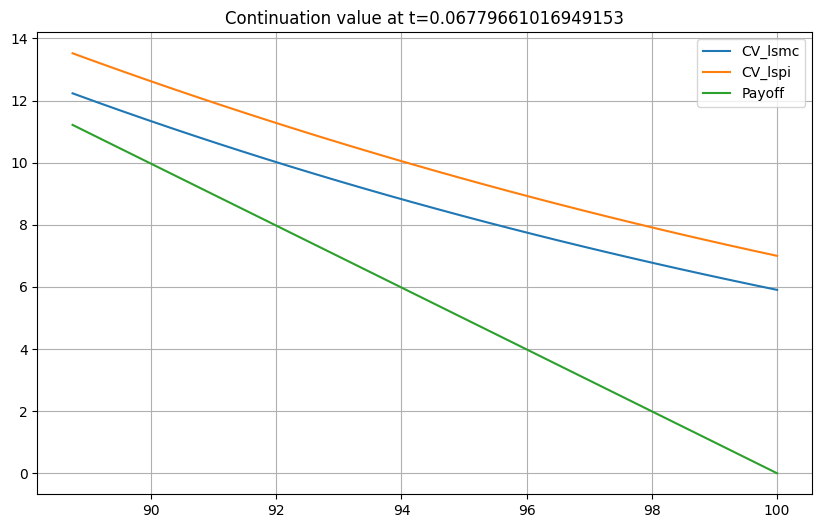

------------------------------------------------------------------------------------------------------------------------


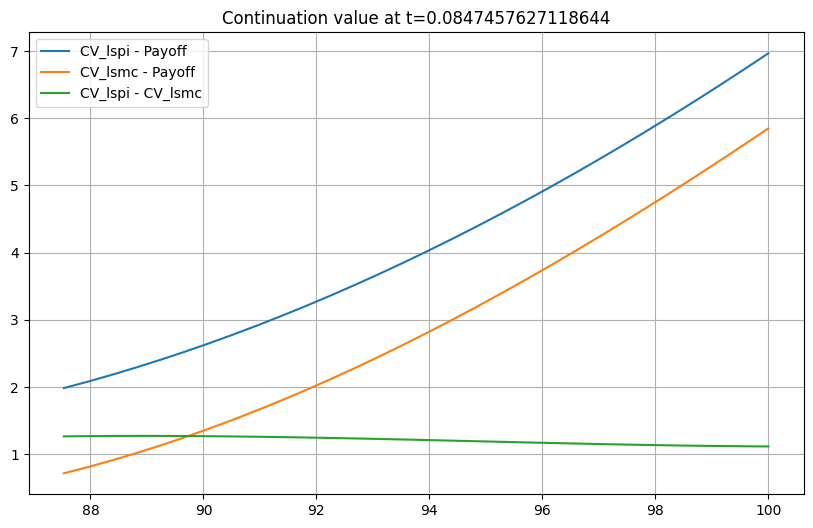

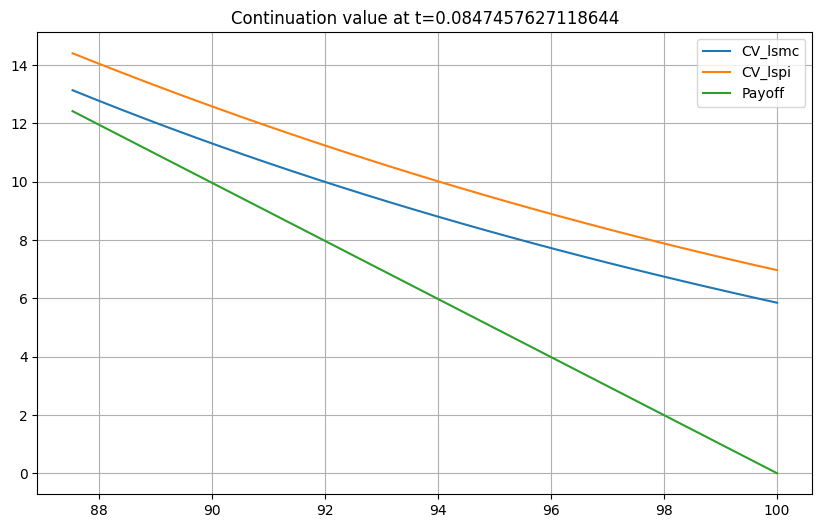

------------------------------------------------------------------------------------------------------------------------


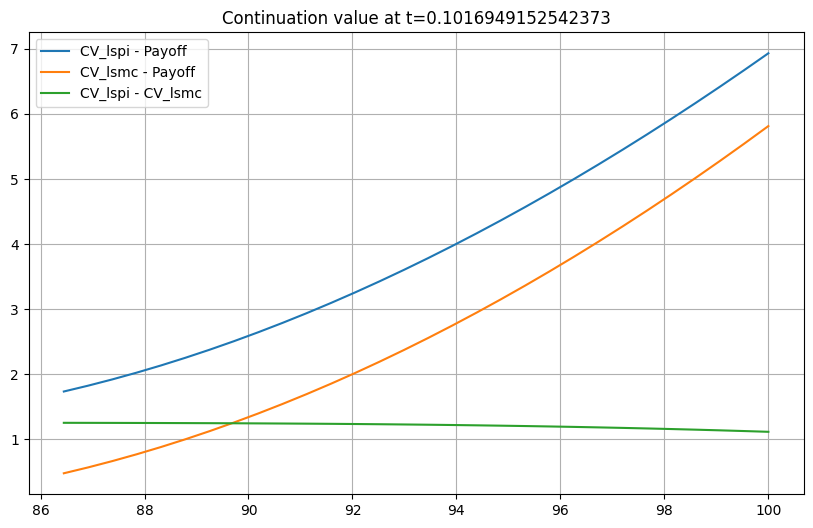

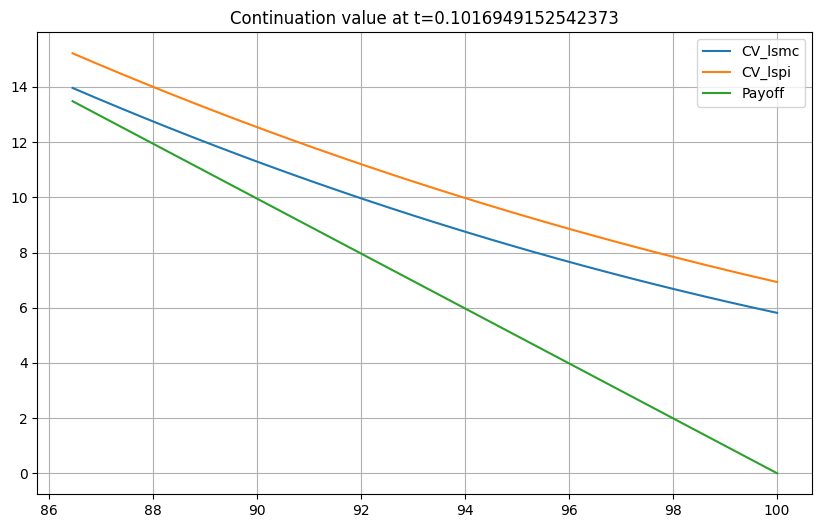

------------------------------------------------------------------------------------------------------------------------


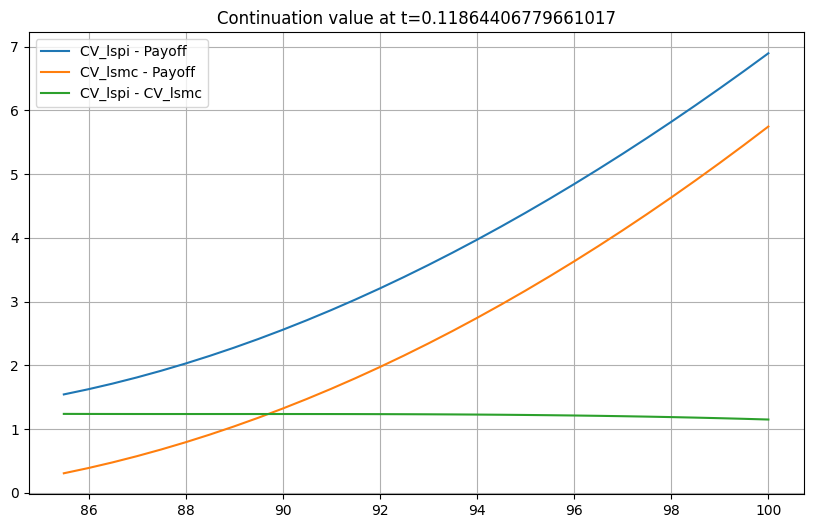

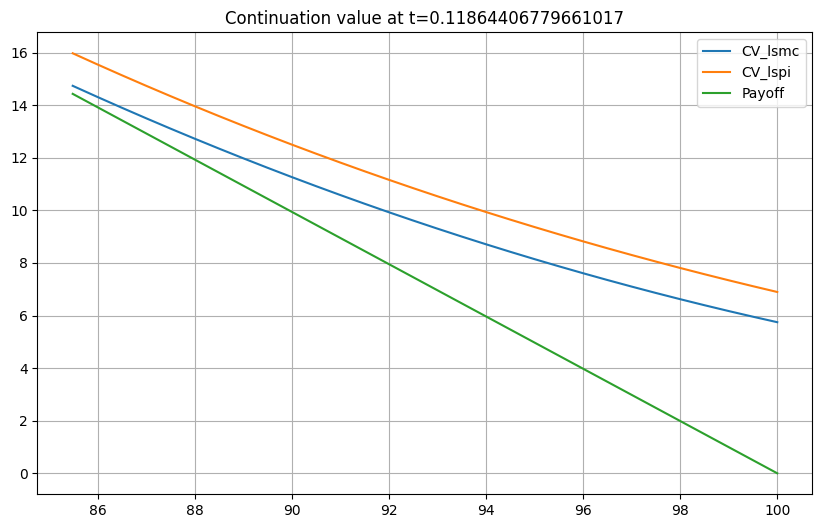

------------------------------------------------------------------------------------------------------------------------


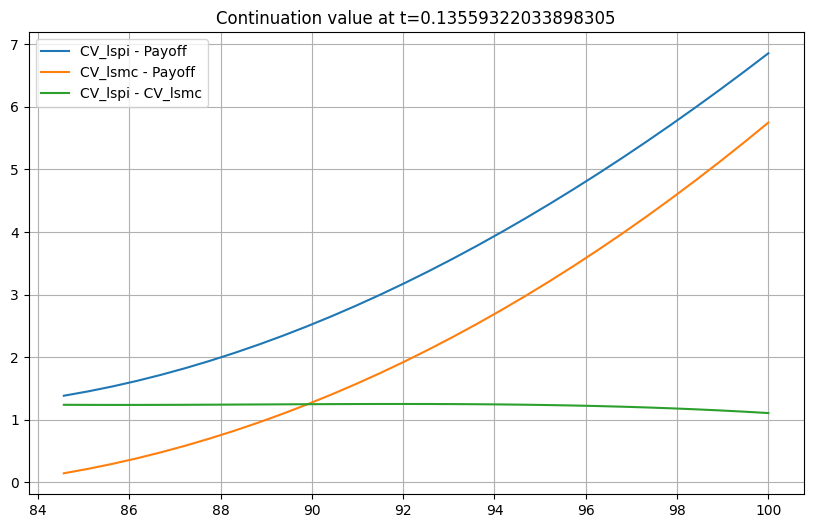

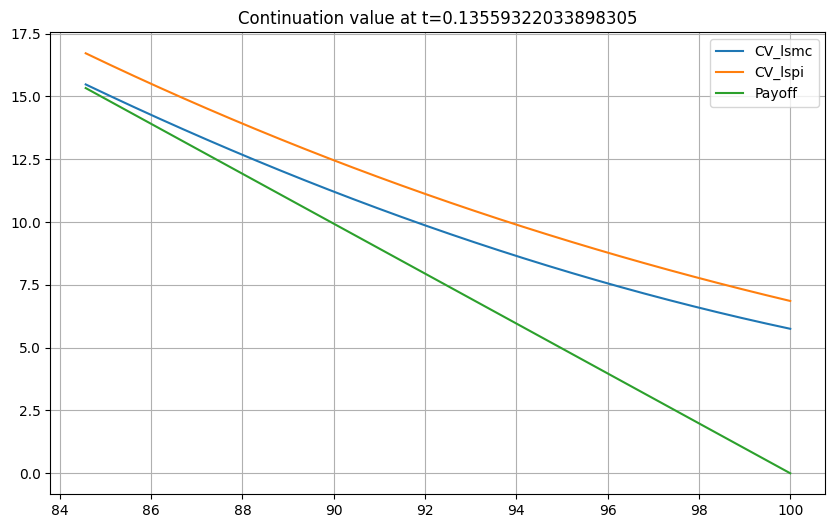

------------------------------------------------------------------------------------------------------------------------


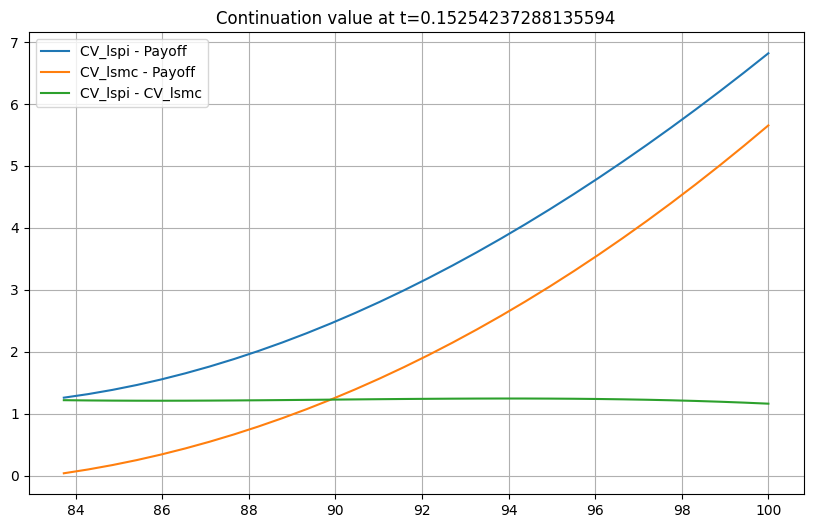

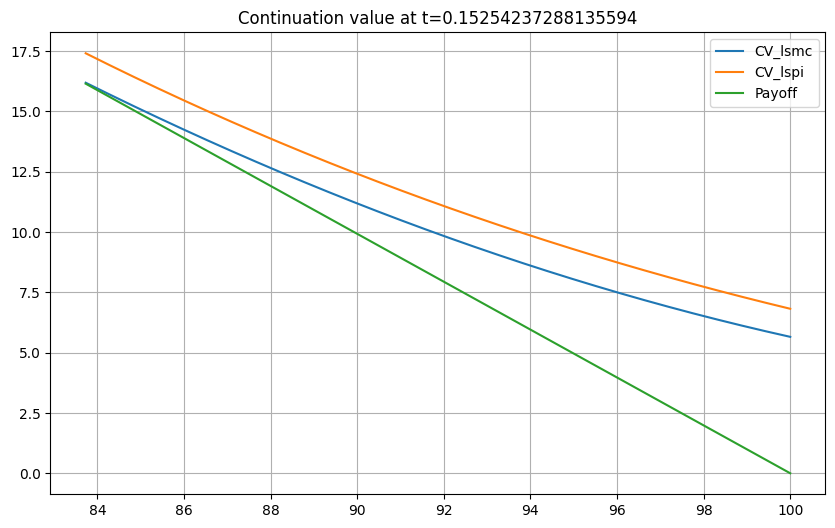

------------------------------------------------------------------------------------------------------------------------


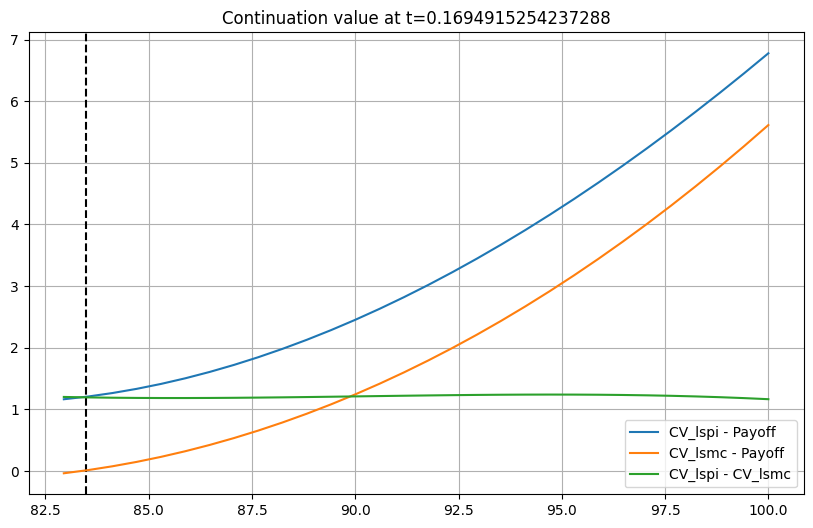

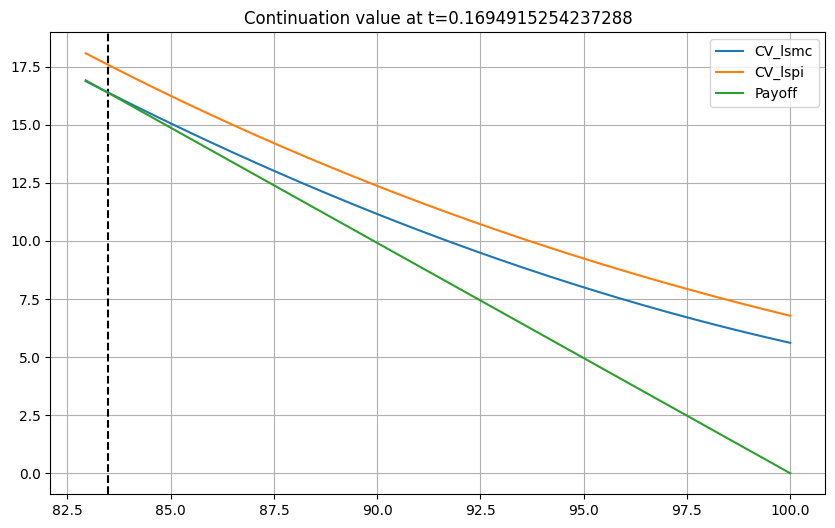

------------------------------------------------------------------------------------------------------------------------


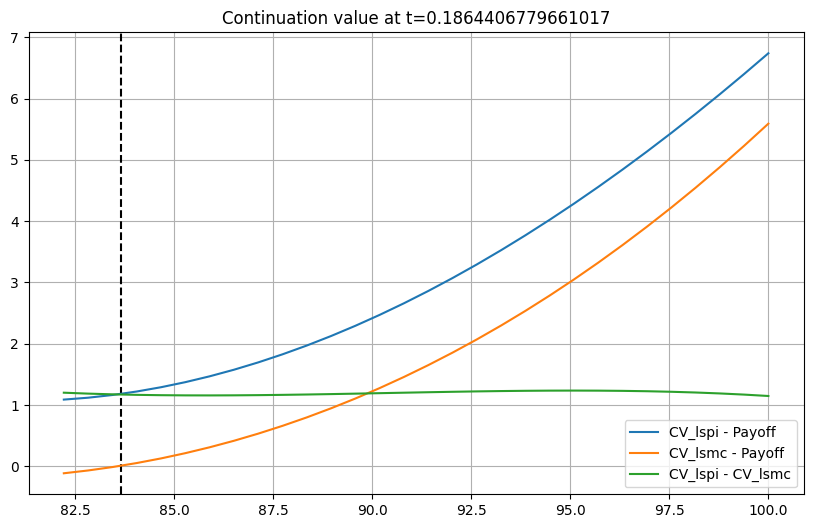

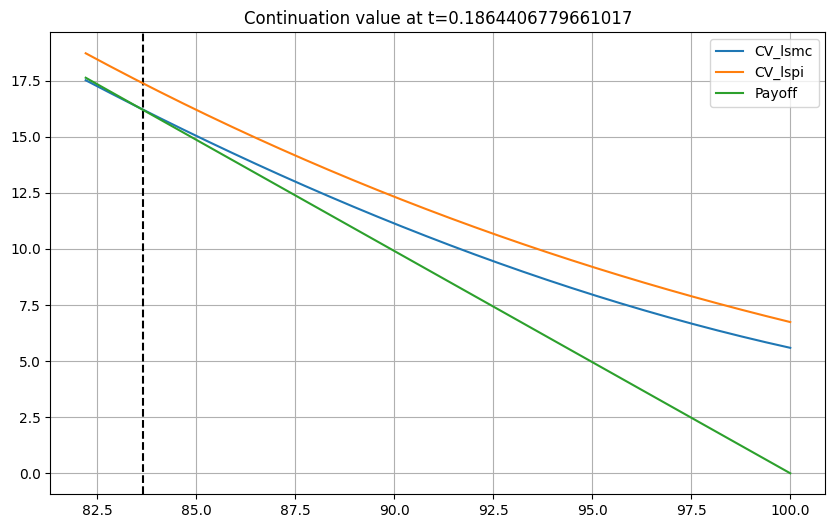

------------------------------------------------------------------------------------------------------------------------


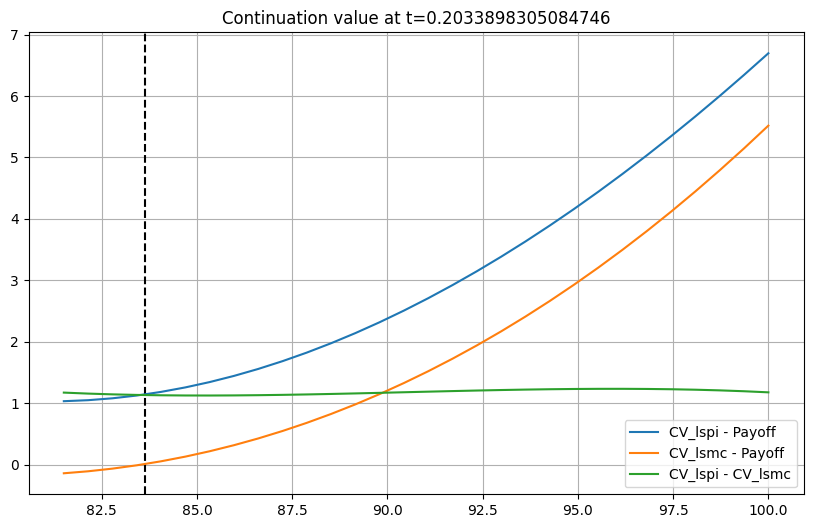

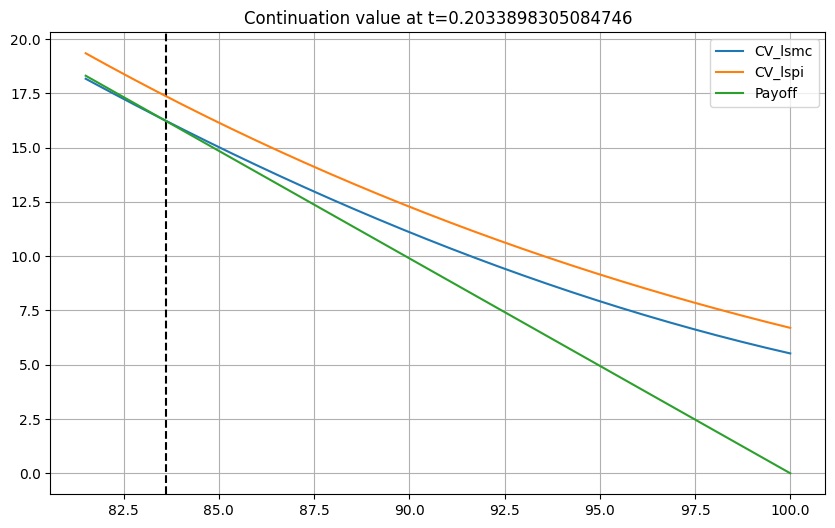

------------------------------------------------------------------------------------------------------------------------


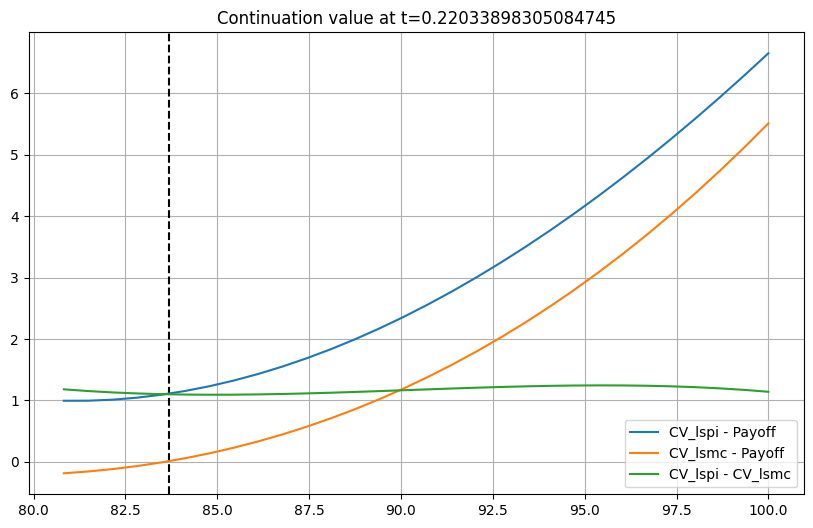

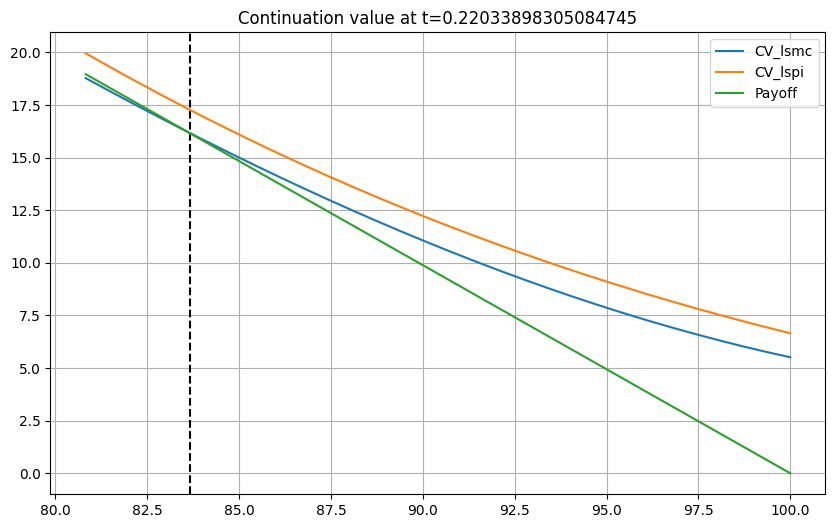

------------------------------------------------------------------------------------------------------------------------


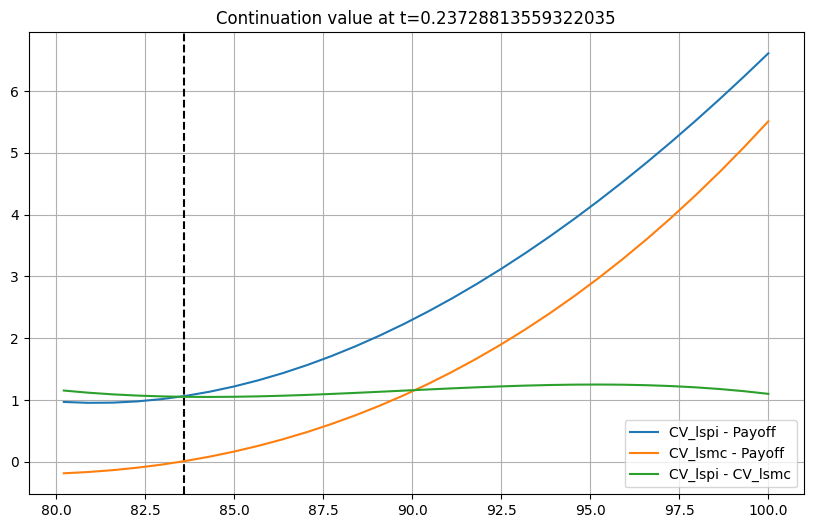

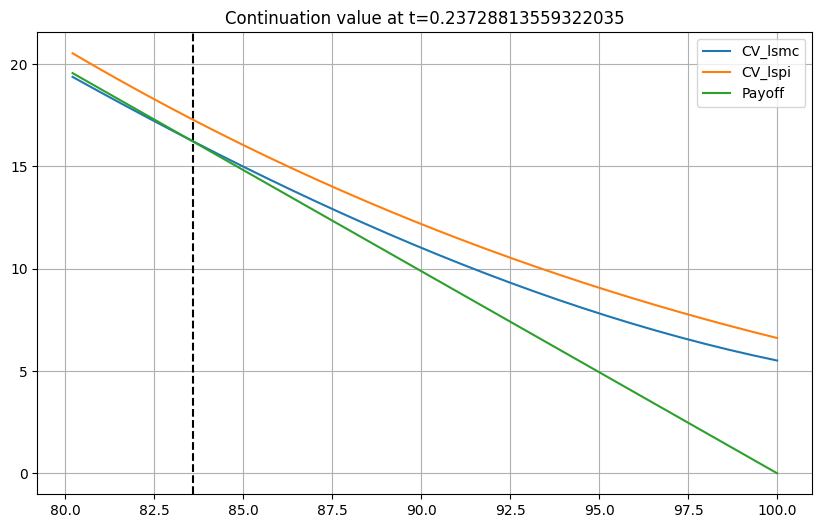

------------------------------------------------------------------------------------------------------------------------


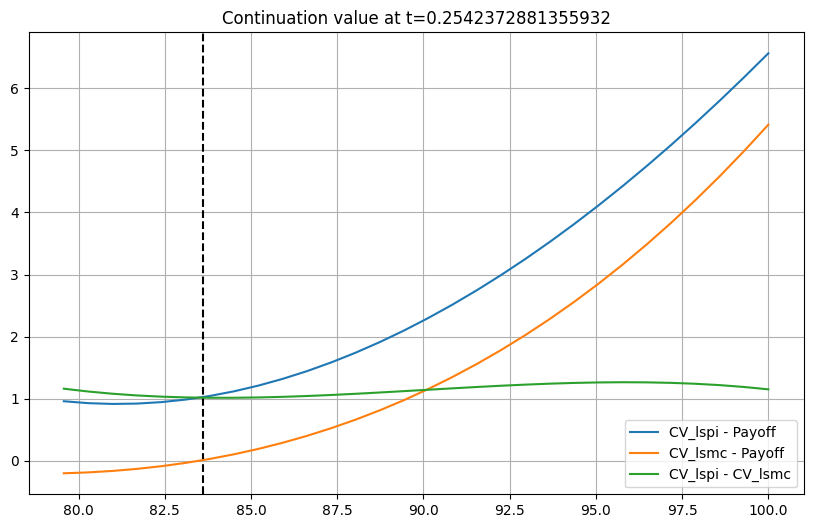

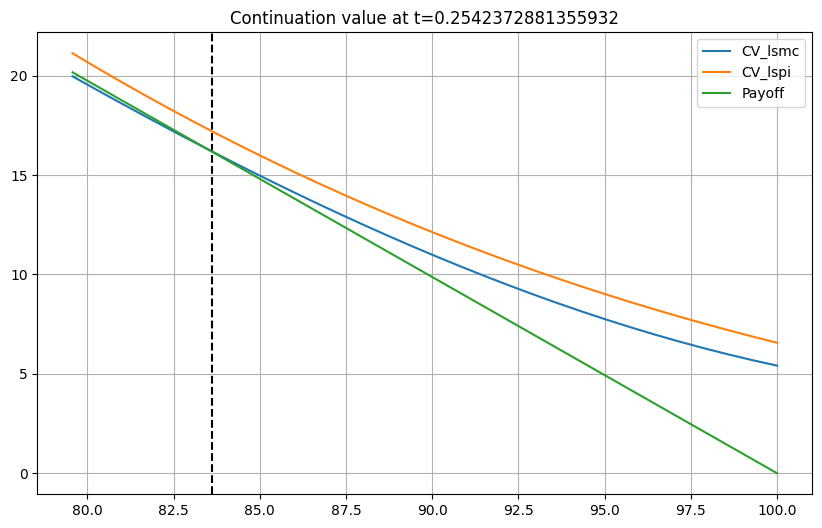

------------------------------------------------------------------------------------------------------------------------


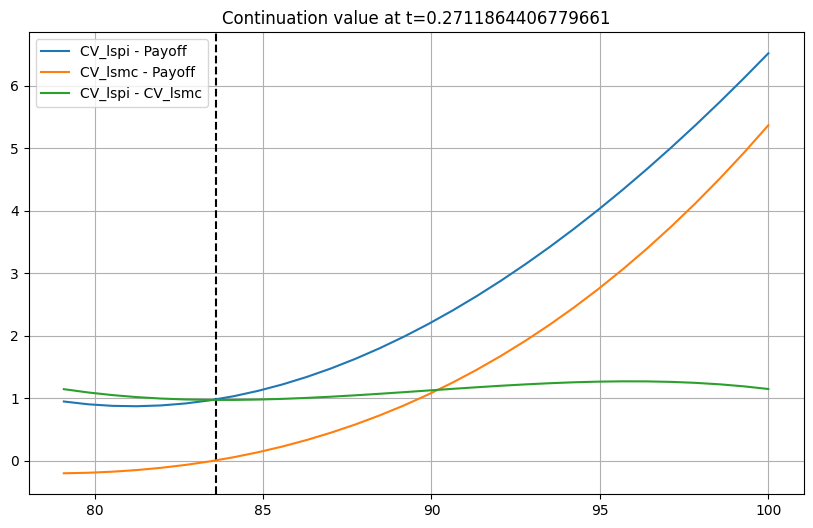

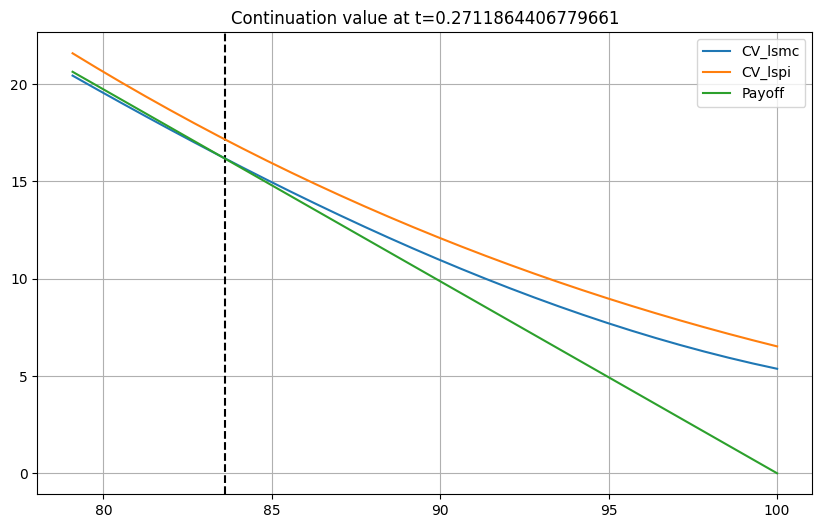

------------------------------------------------------------------------------------------------------------------------


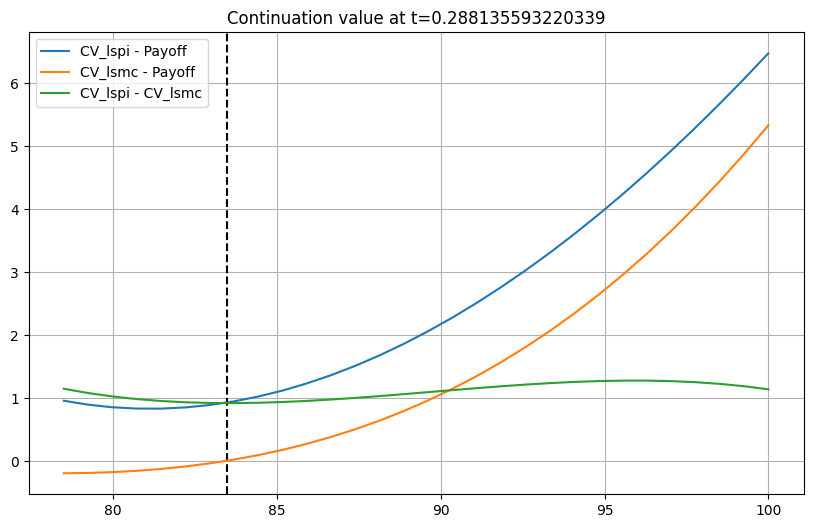

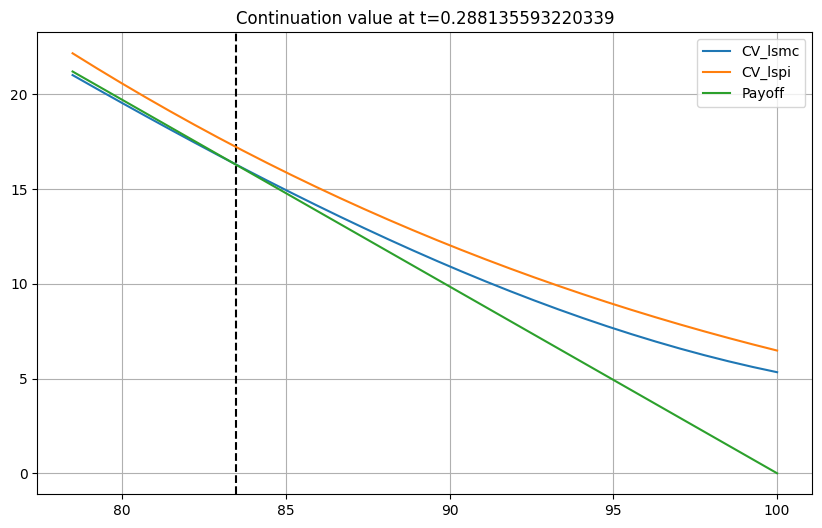

------------------------------------------------------------------------------------------------------------------------


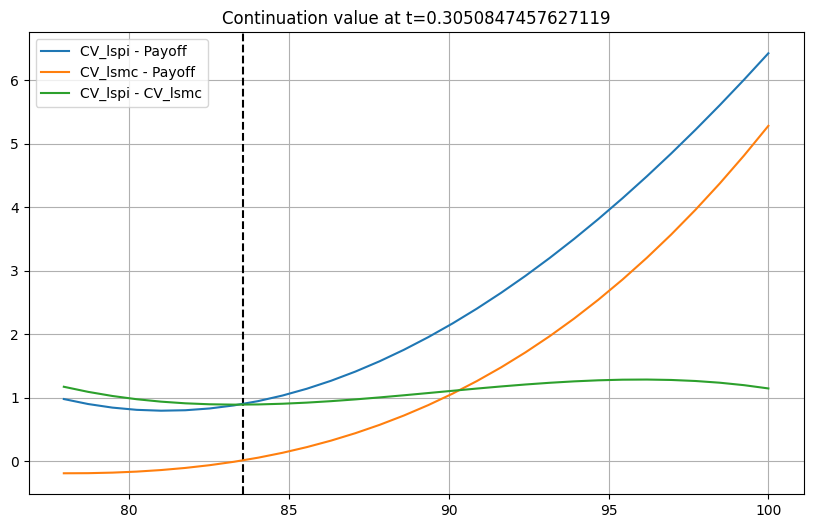

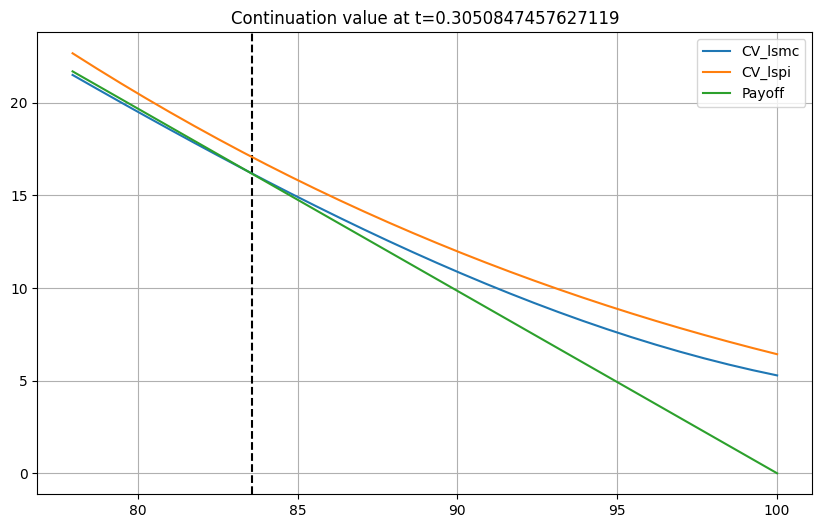

------------------------------------------------------------------------------------------------------------------------


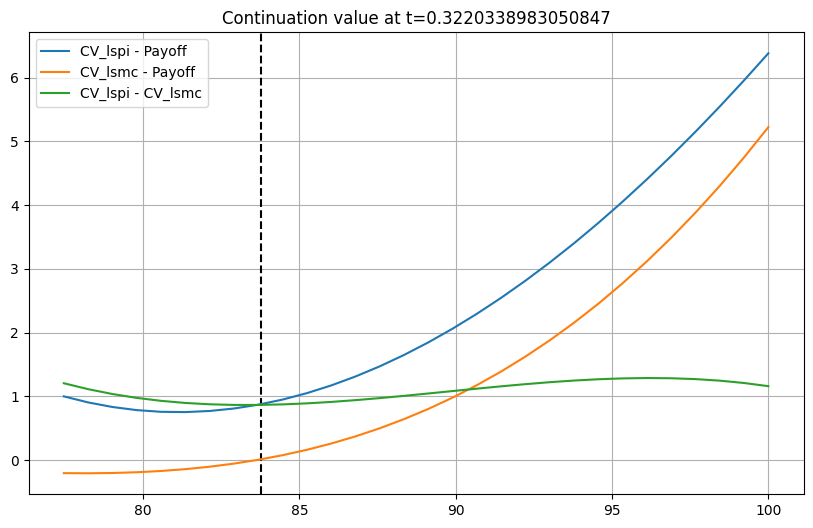

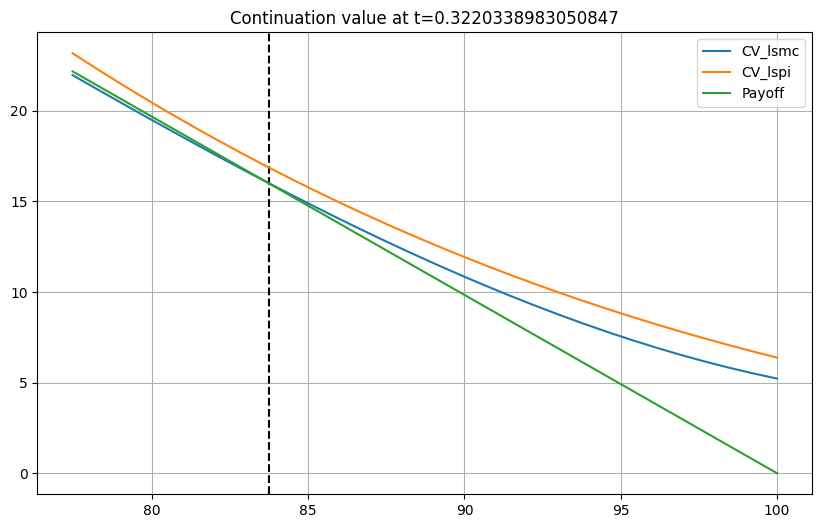

------------------------------------------------------------------------------------------------------------------------


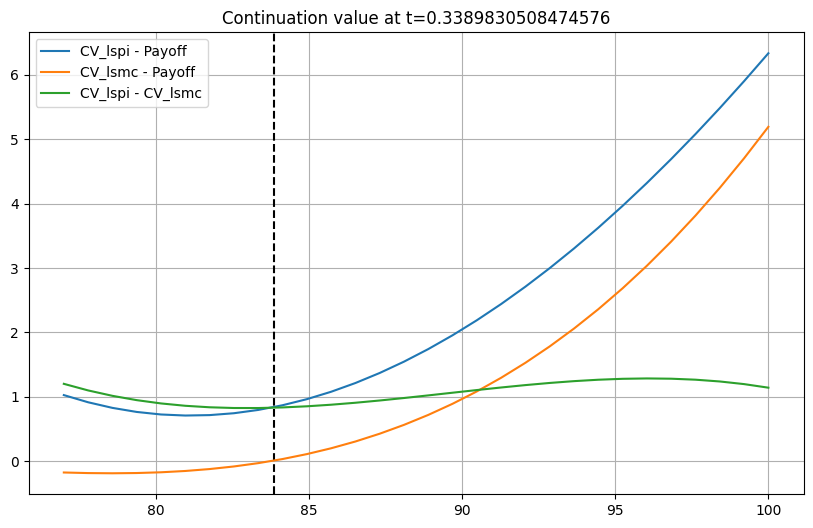

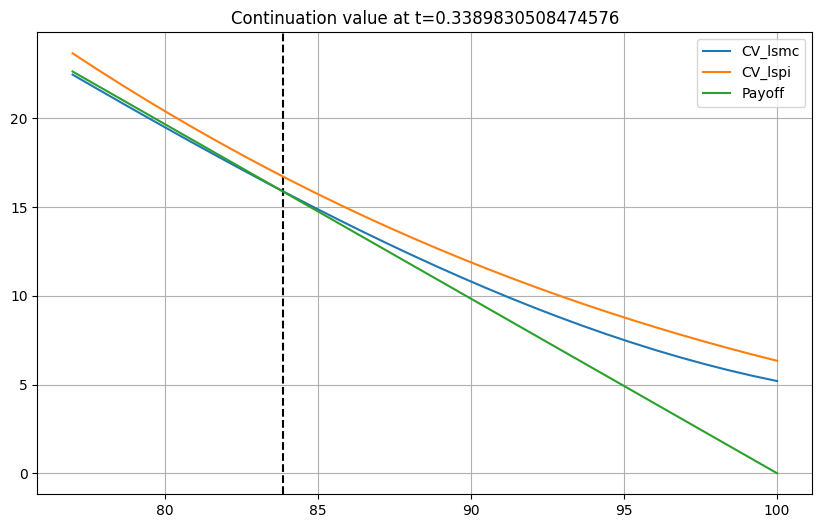

------------------------------------------------------------------------------------------------------------------------


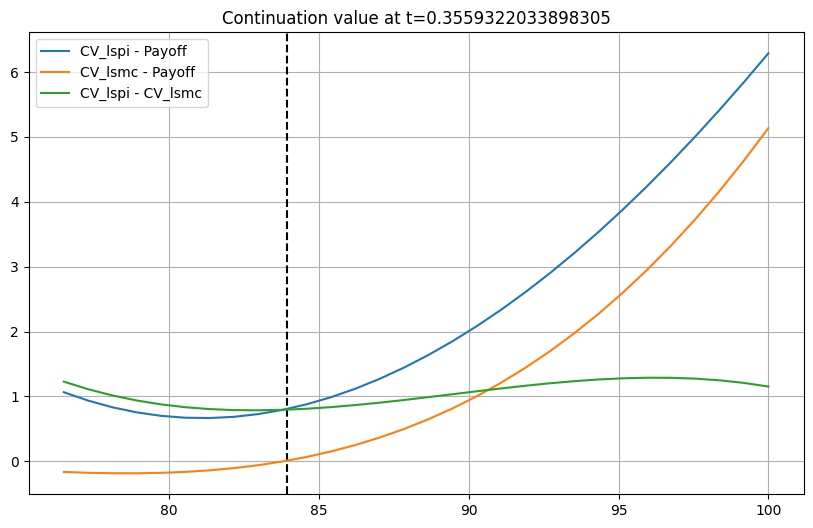

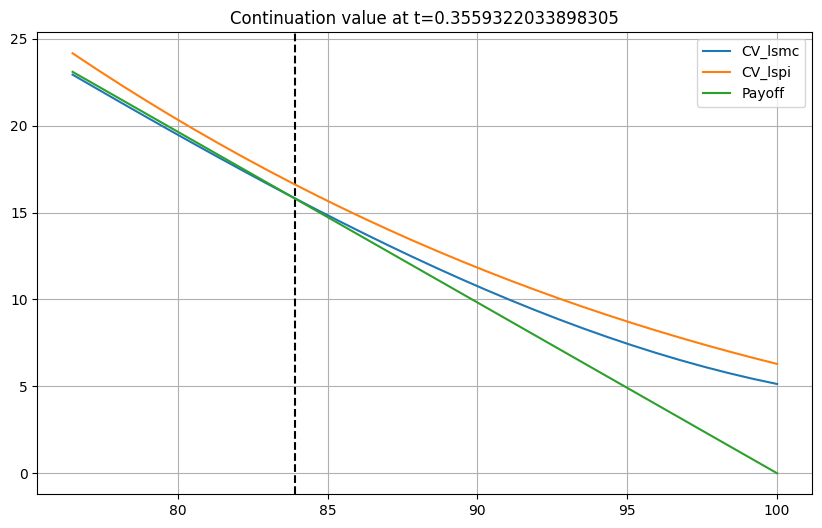

------------------------------------------------------------------------------------------------------------------------


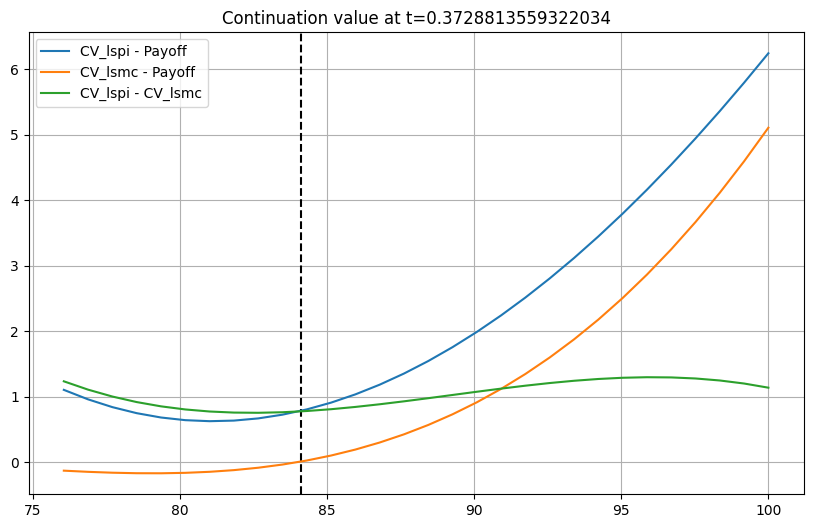

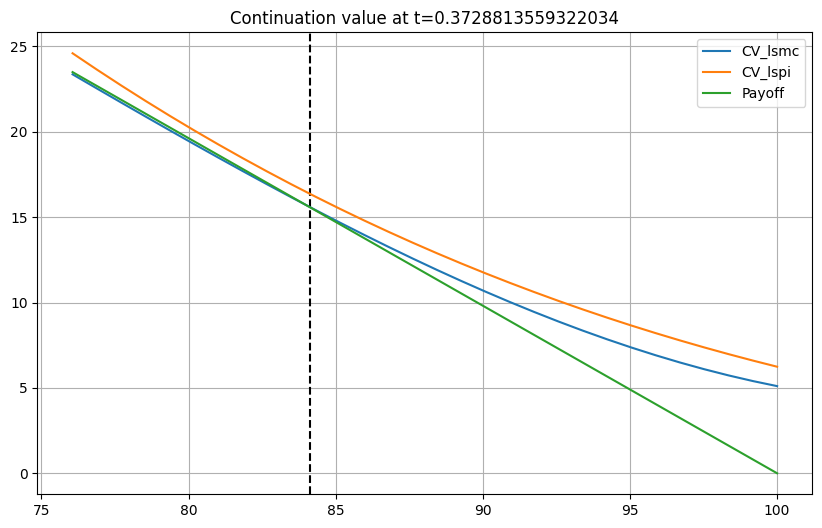

------------------------------------------------------------------------------------------------------------------------


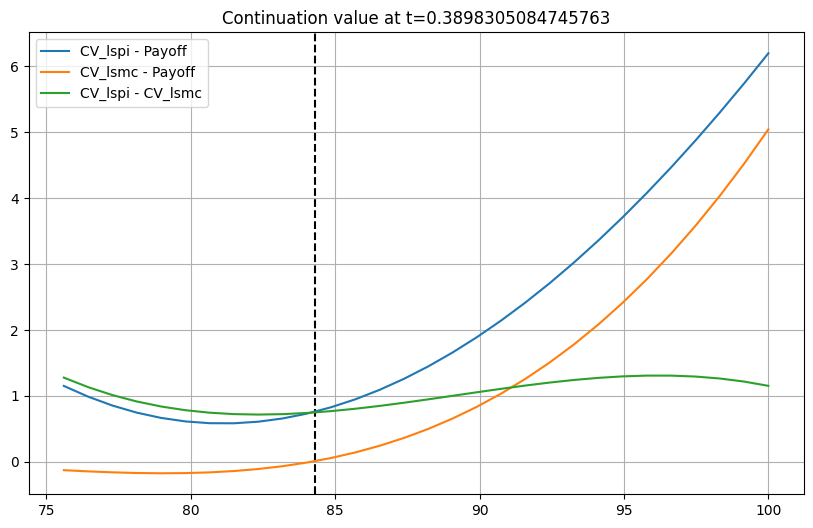

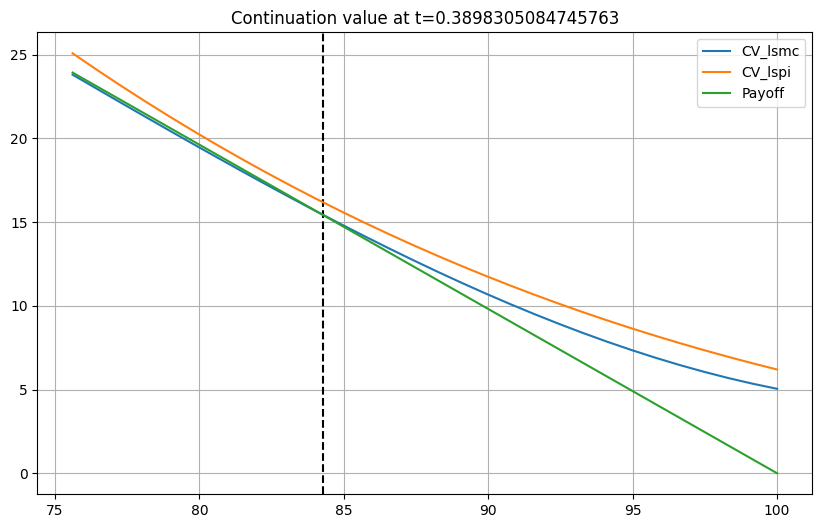

------------------------------------------------------------------------------------------------------------------------


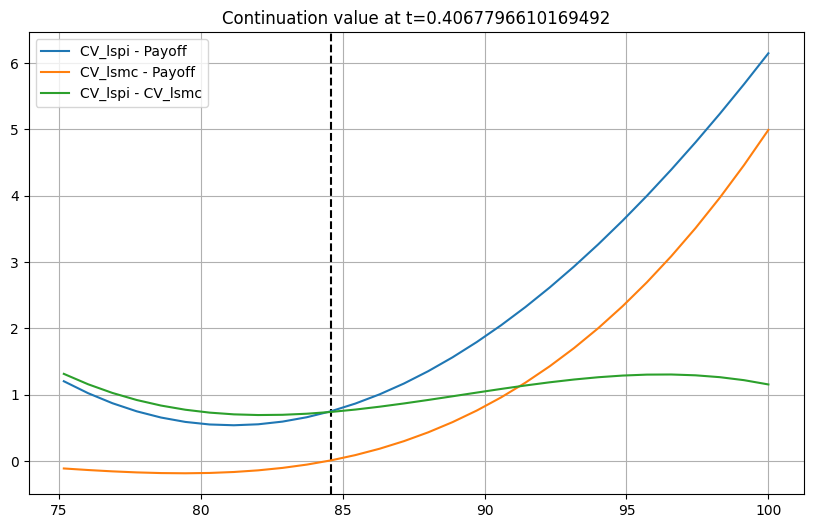

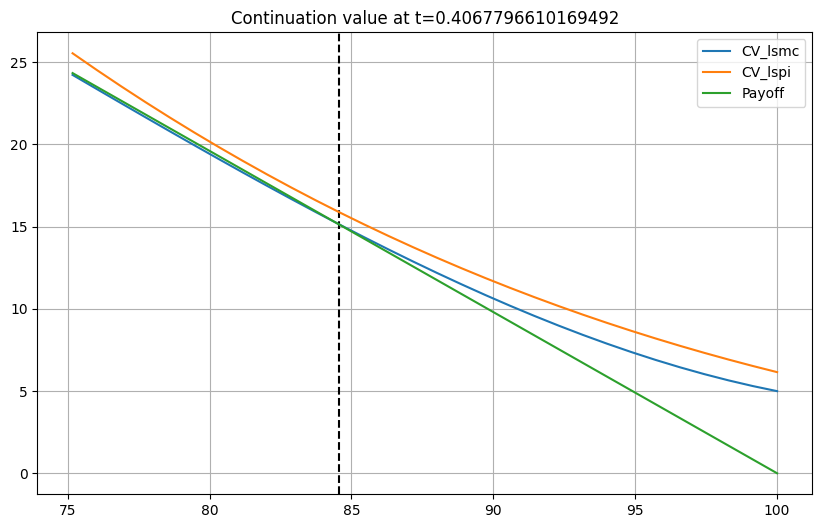

------------------------------------------------------------------------------------------------------------------------


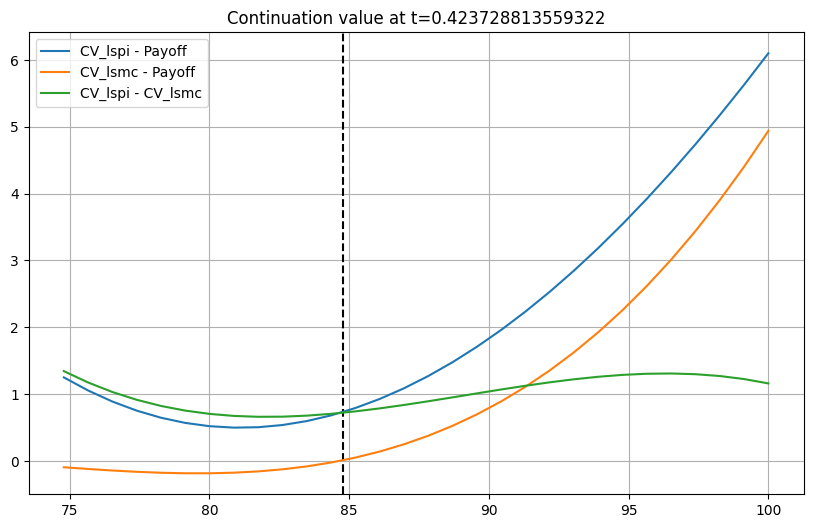

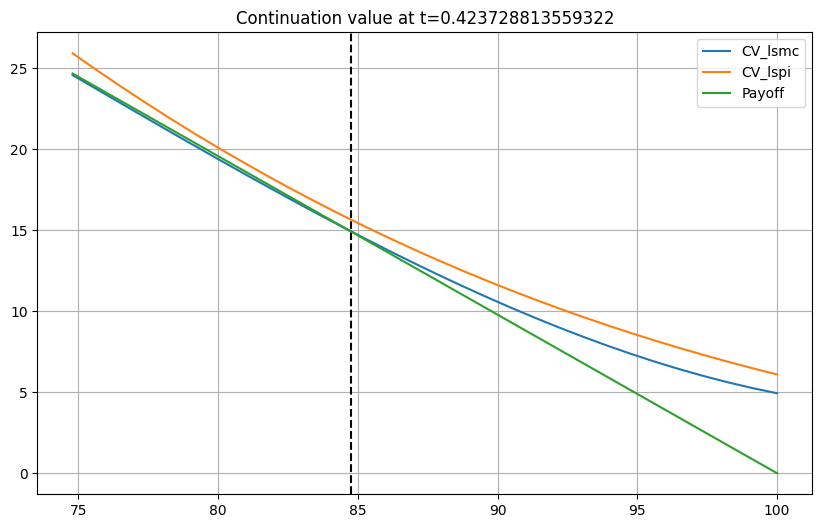

------------------------------------------------------------------------------------------------------------------------


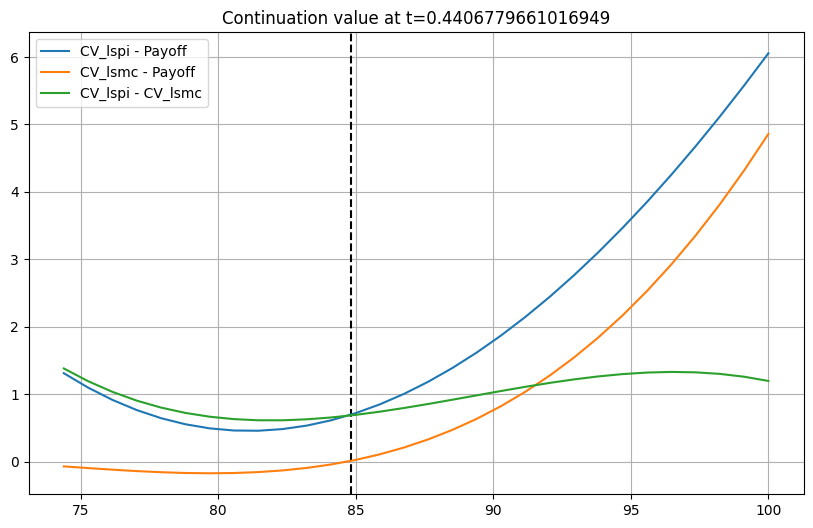

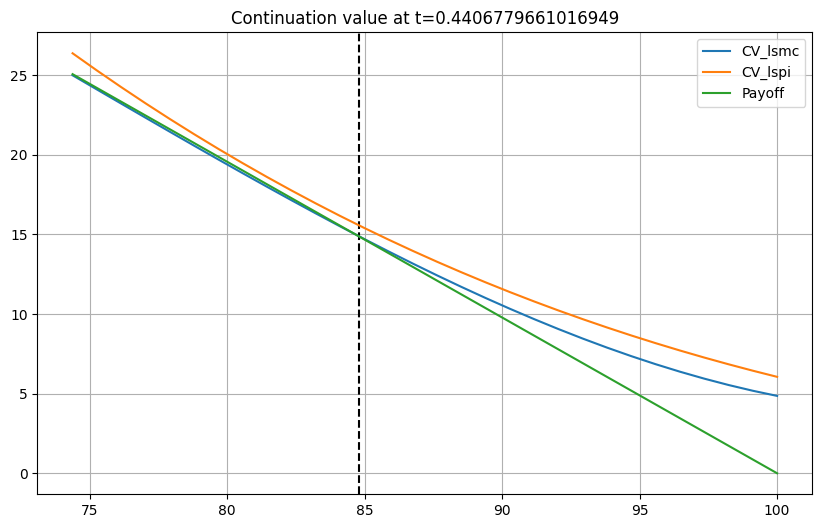

------------------------------------------------------------------------------------------------------------------------


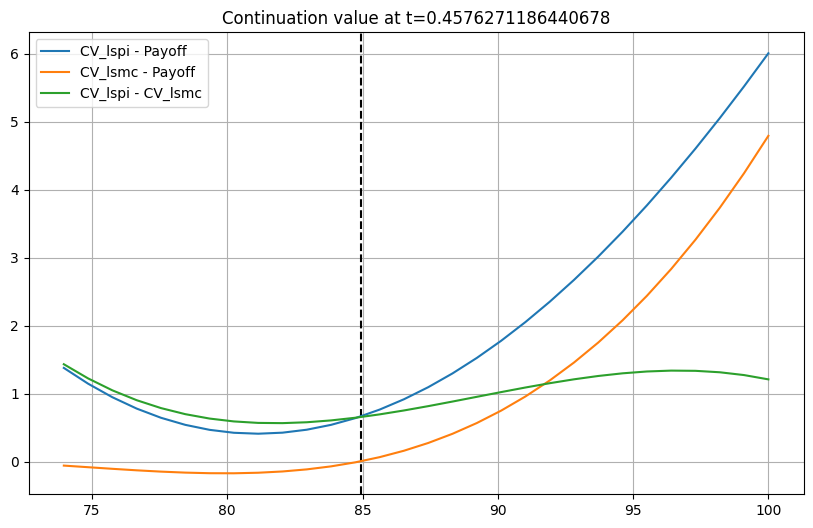

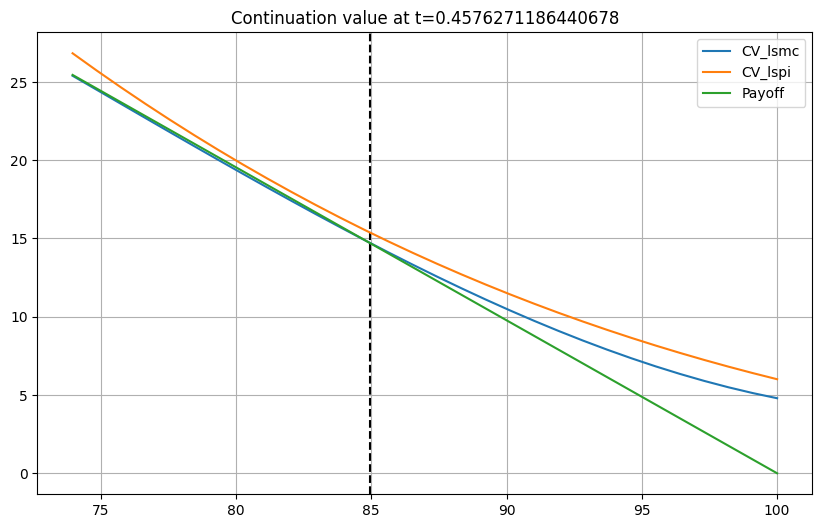

------------------------------------------------------------------------------------------------------------------------


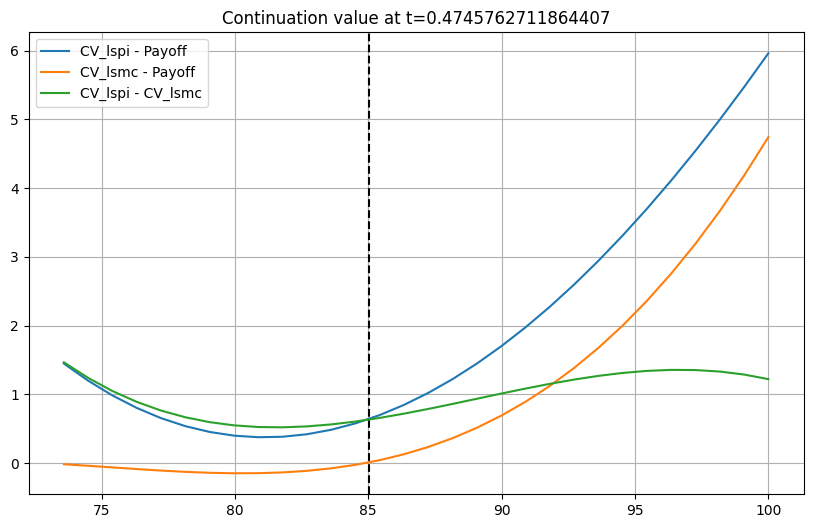

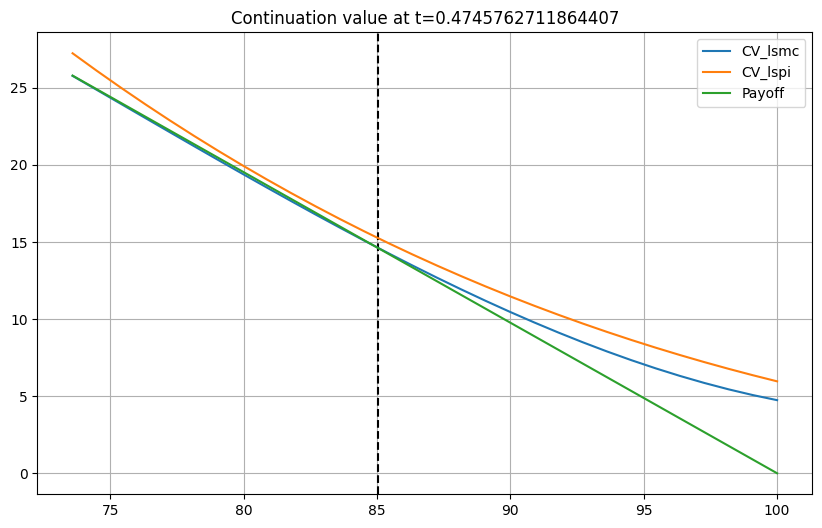

------------------------------------------------------------------------------------------------------------------------


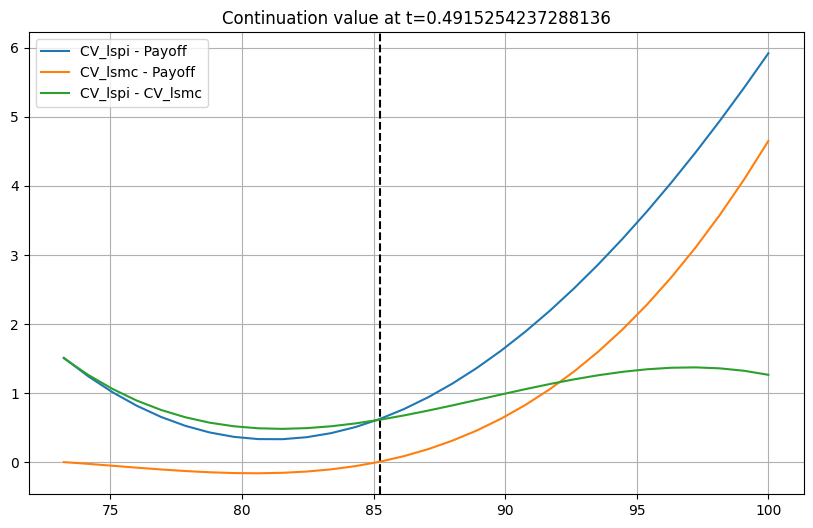

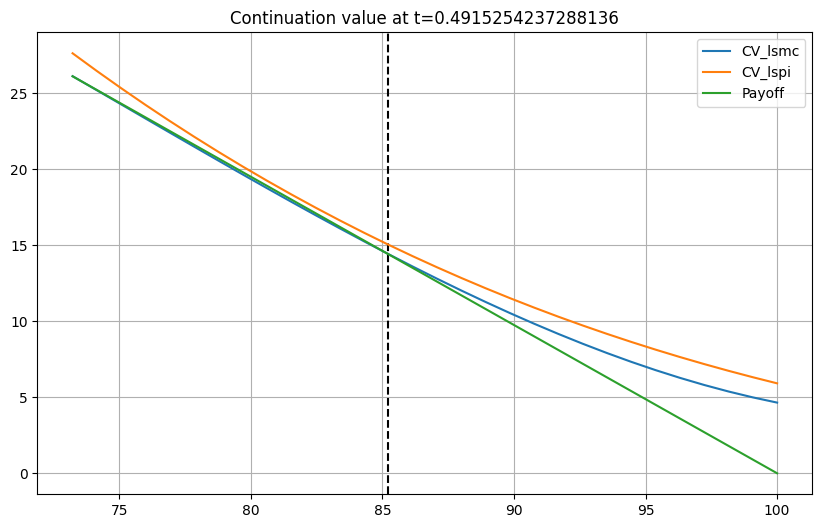

------------------------------------------------------------------------------------------------------------------------


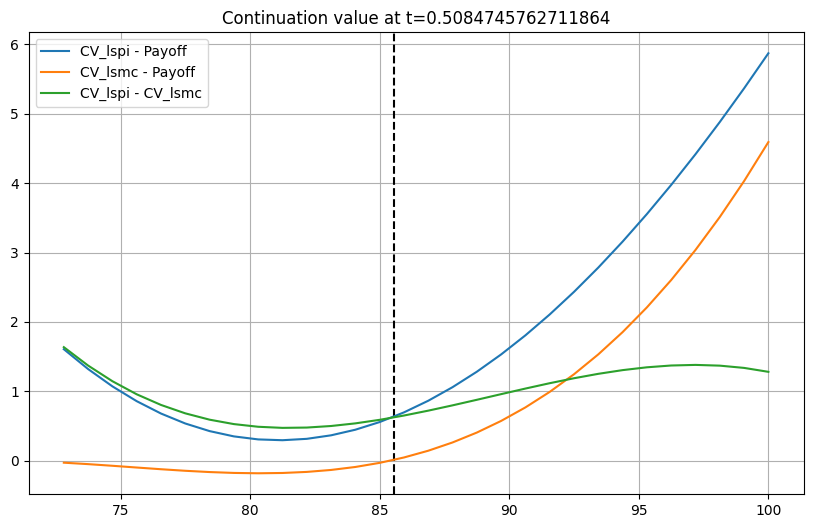

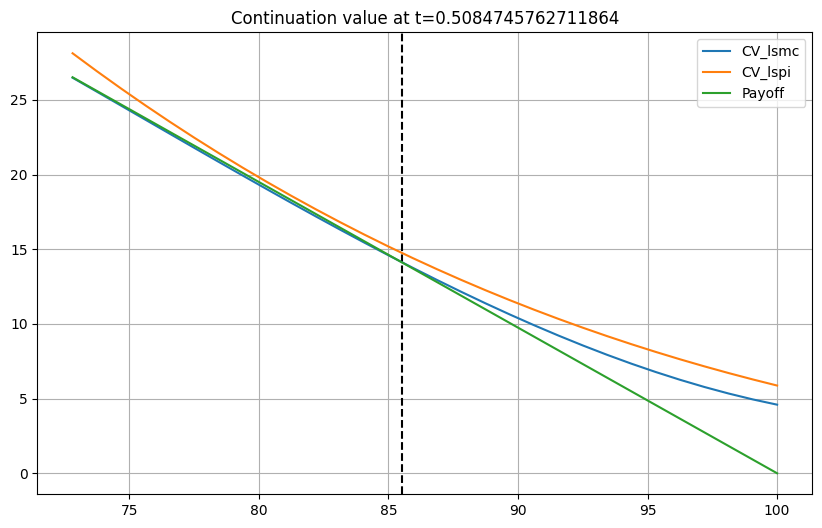

------------------------------------------------------------------------------------------------------------------------


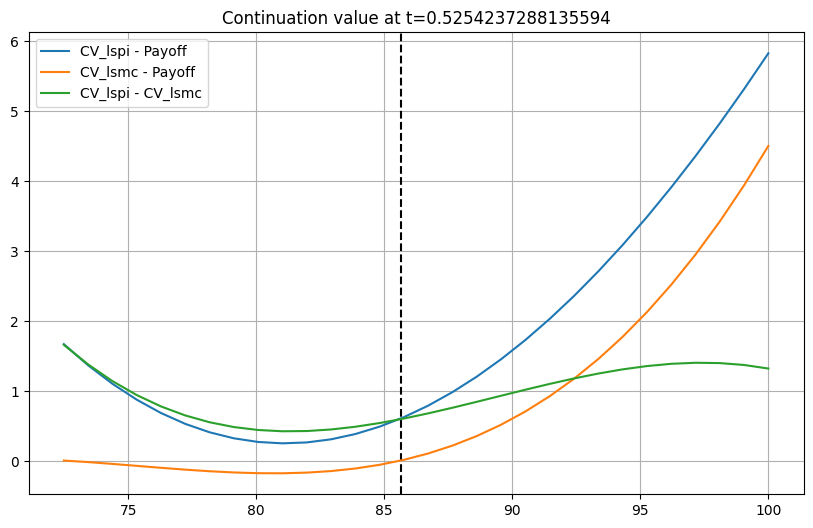

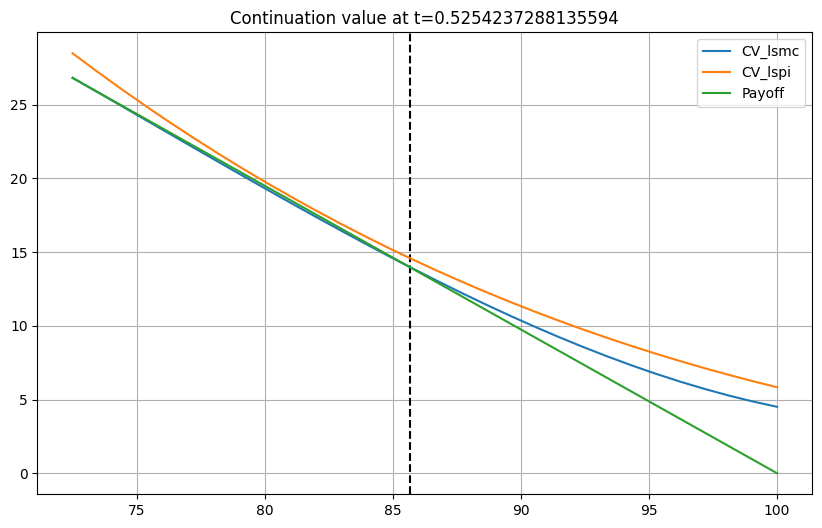

------------------------------------------------------------------------------------------------------------------------


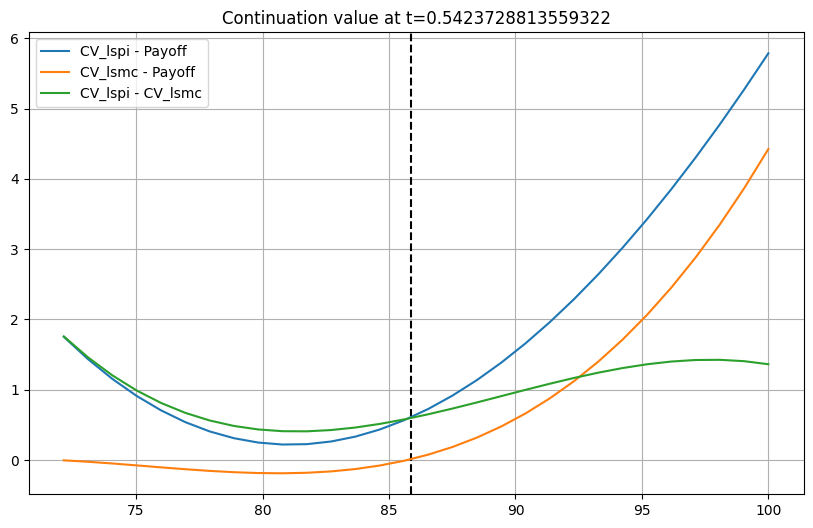

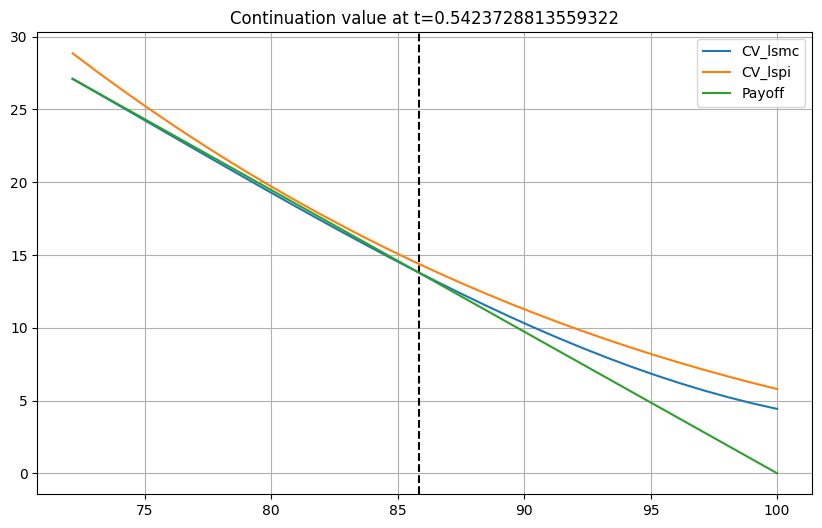

------------------------------------------------------------------------------------------------------------------------


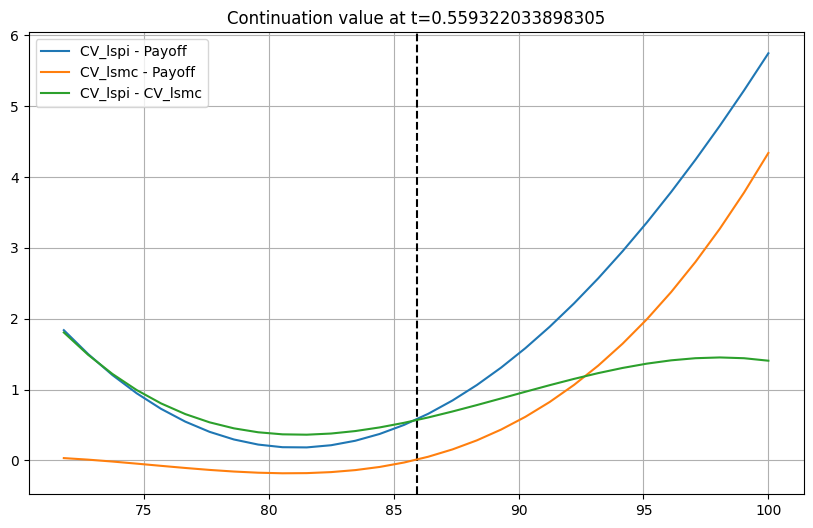

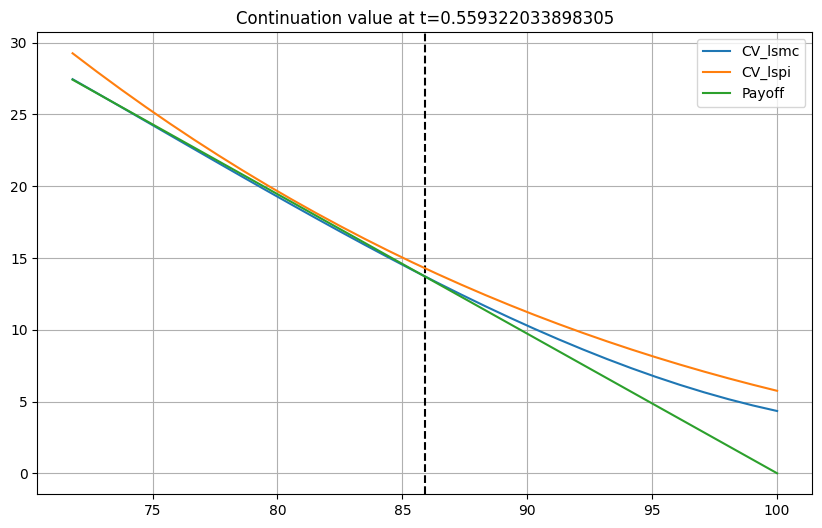

------------------------------------------------------------------------------------------------------------------------


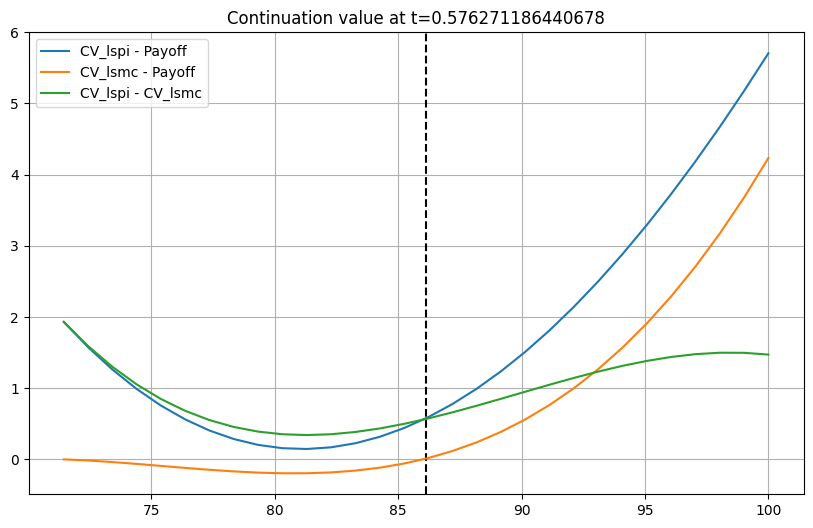

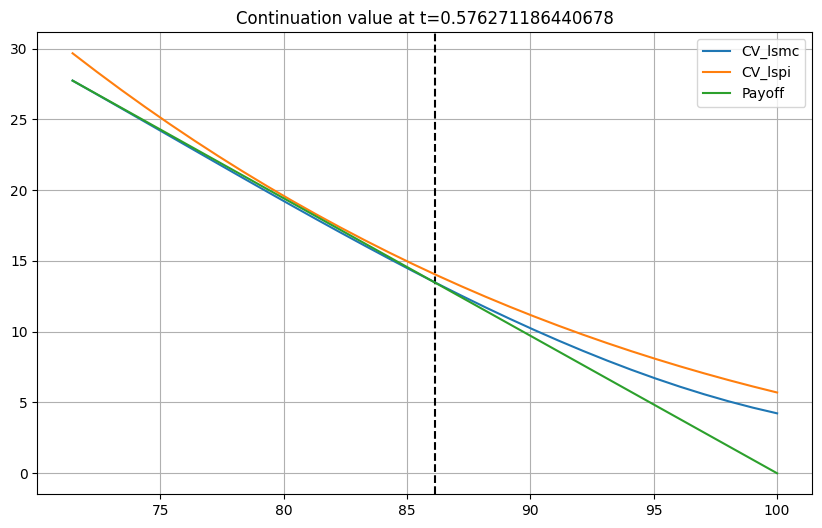

------------------------------------------------------------------------------------------------------------------------


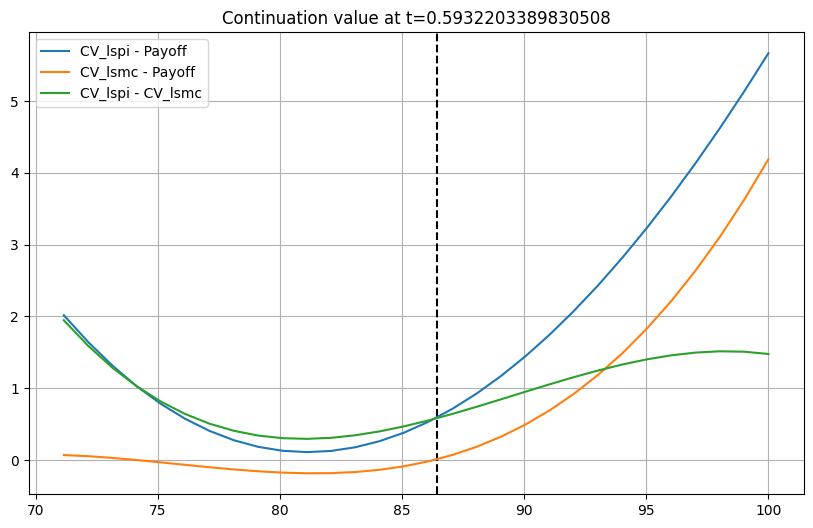

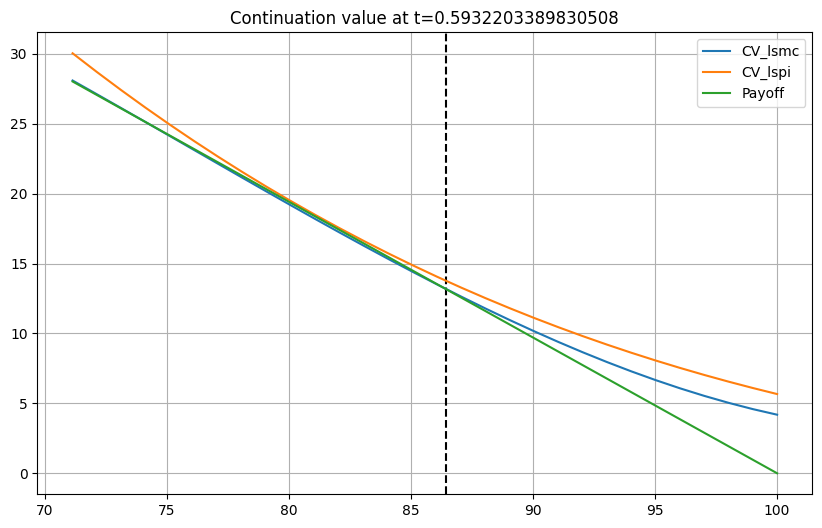

------------------------------------------------------------------------------------------------------------------------


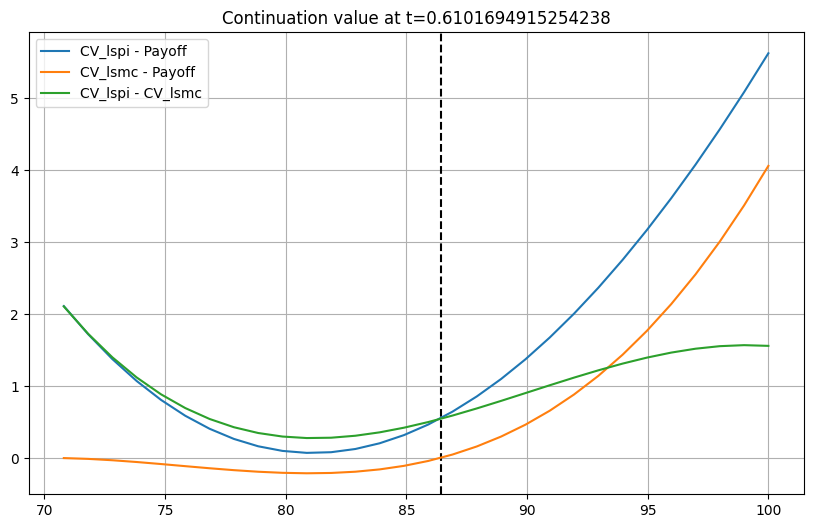

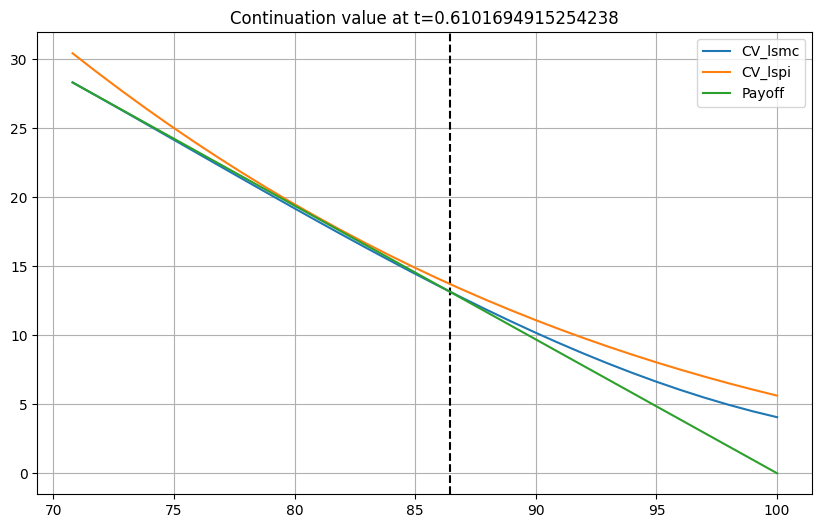

------------------------------------------------------------------------------------------------------------------------


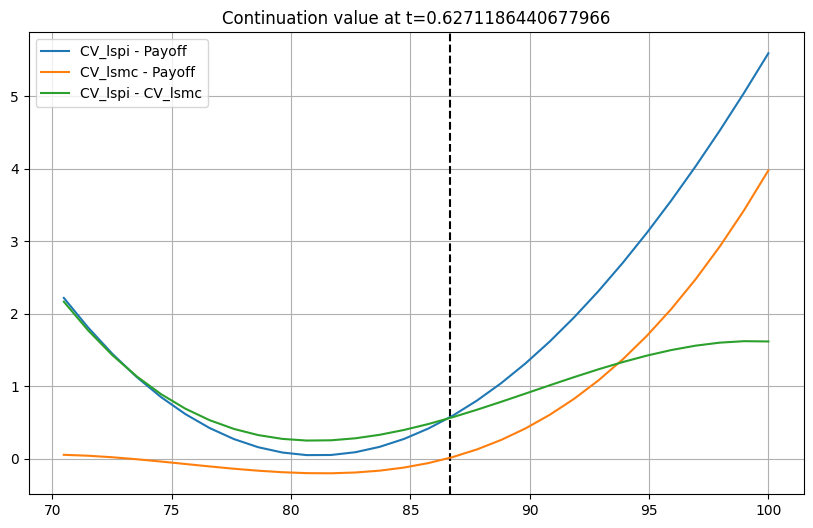

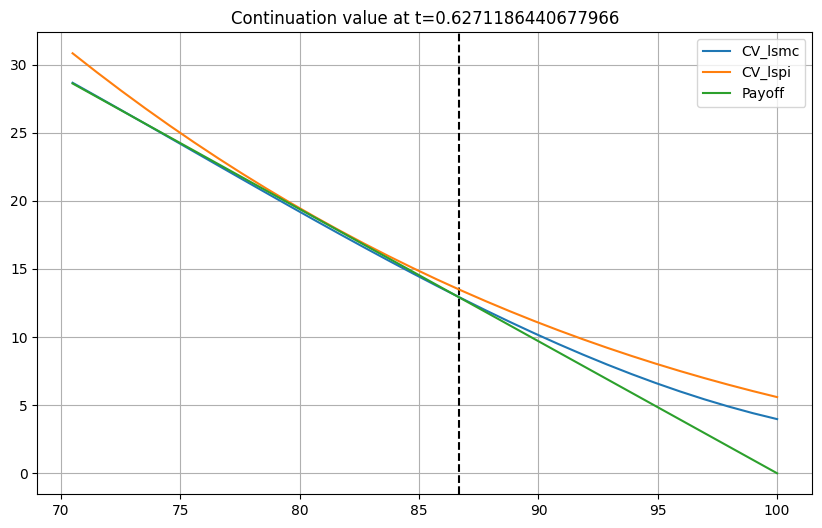

------------------------------------------------------------------------------------------------------------------------


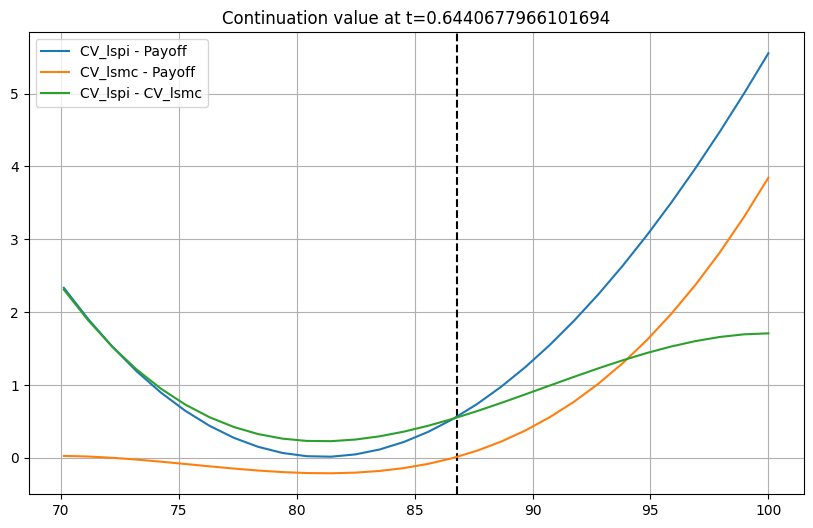

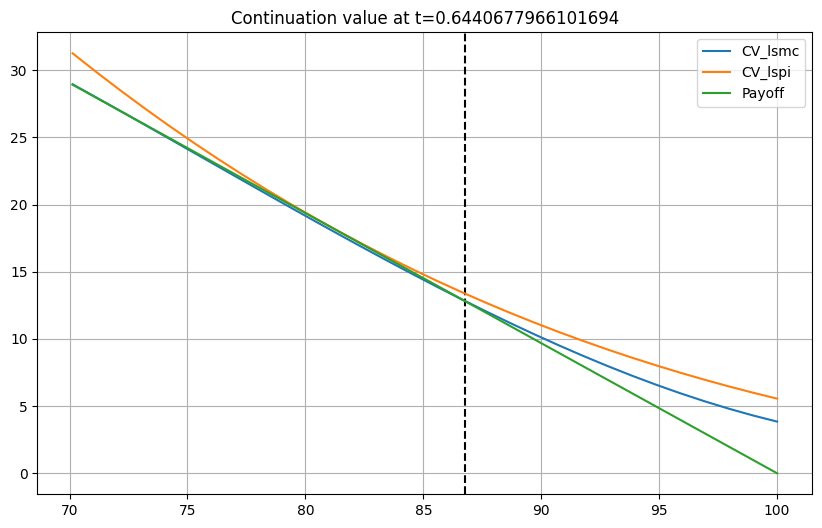

------------------------------------------------------------------------------------------------------------------------


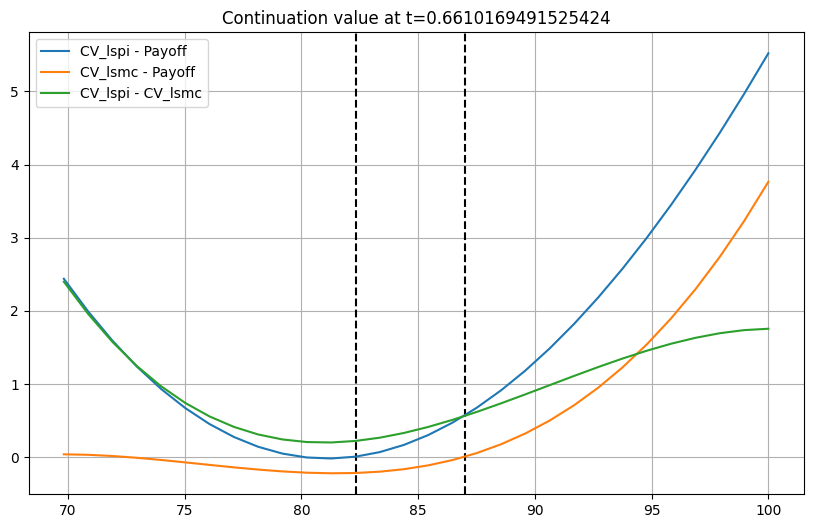

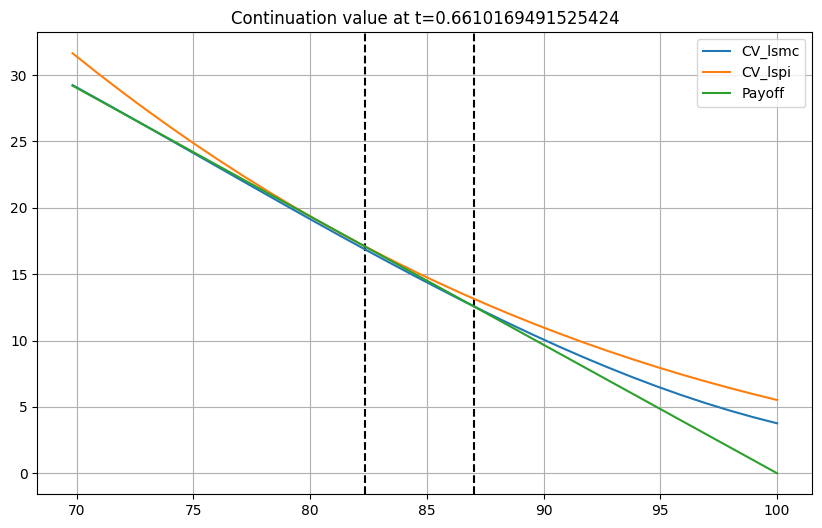

------------------------------------------------------------------------------------------------------------------------


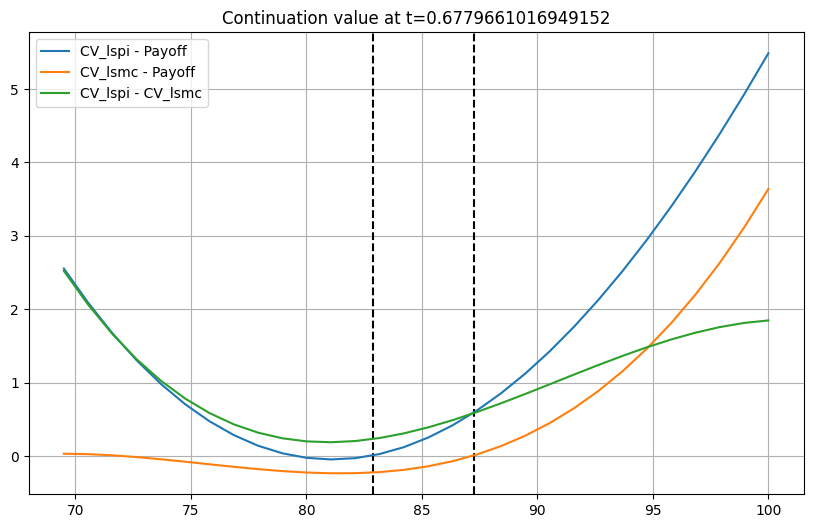

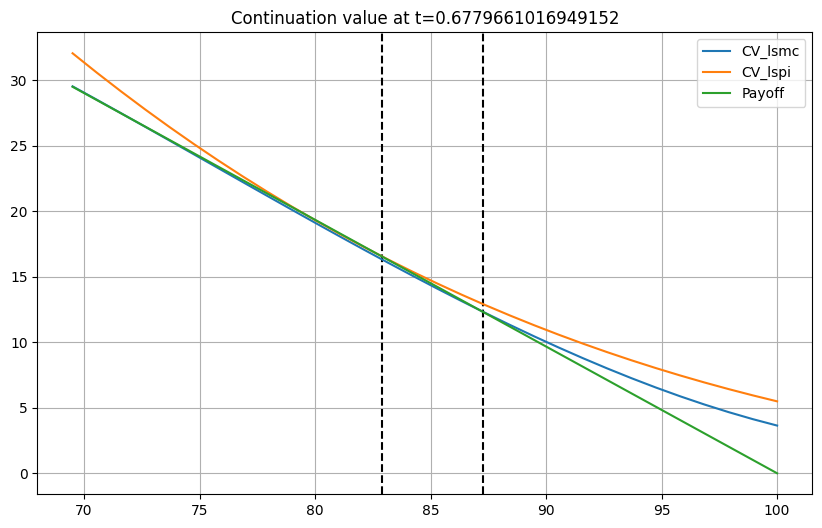

------------------------------------------------------------------------------------------------------------------------


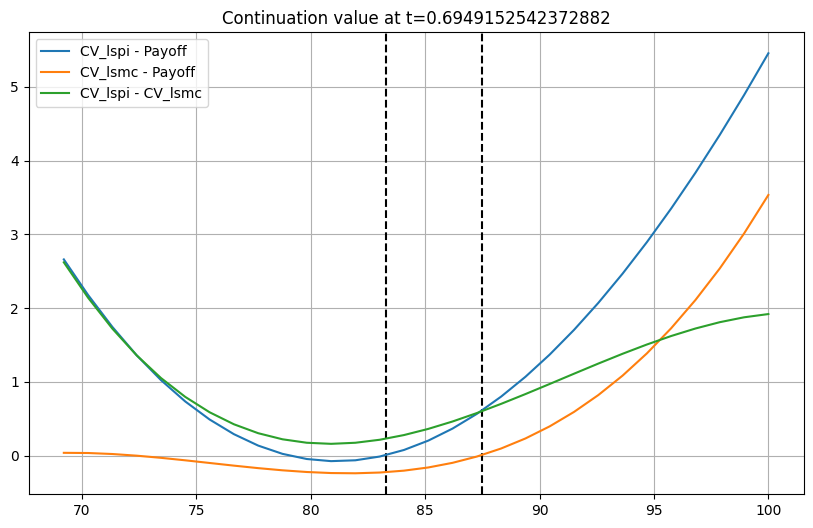

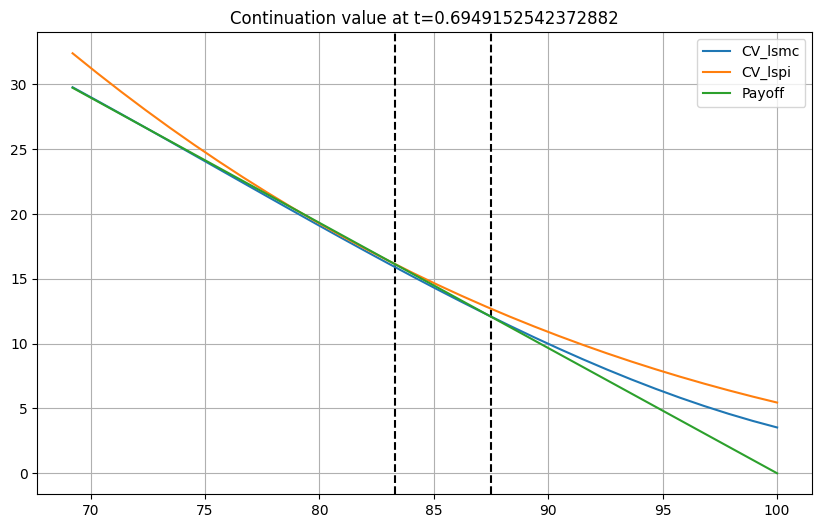

------------------------------------------------------------------------------------------------------------------------


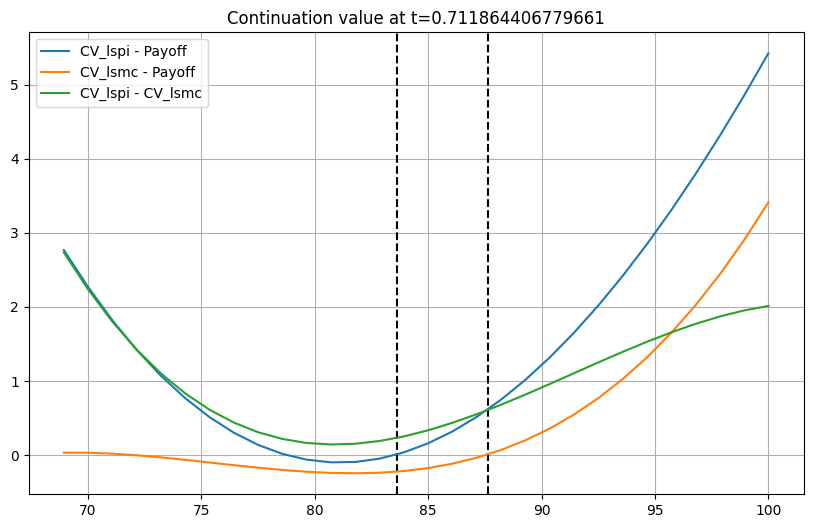

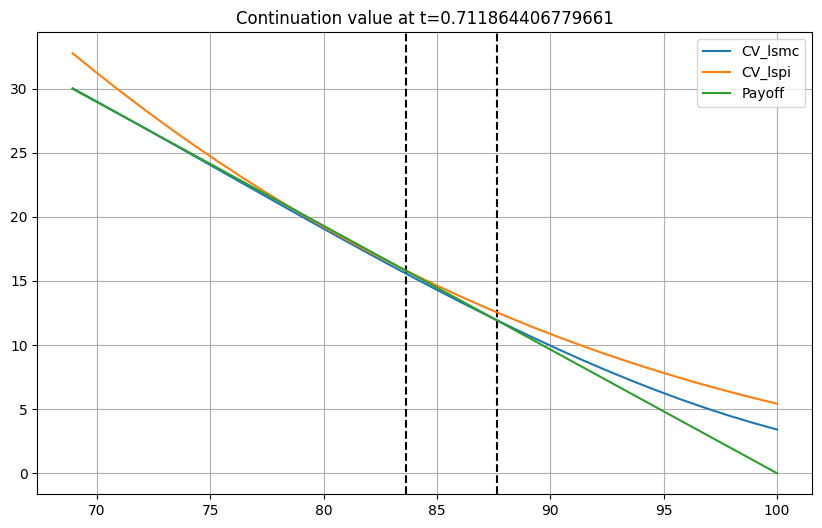

------------------------------------------------------------------------------------------------------------------------


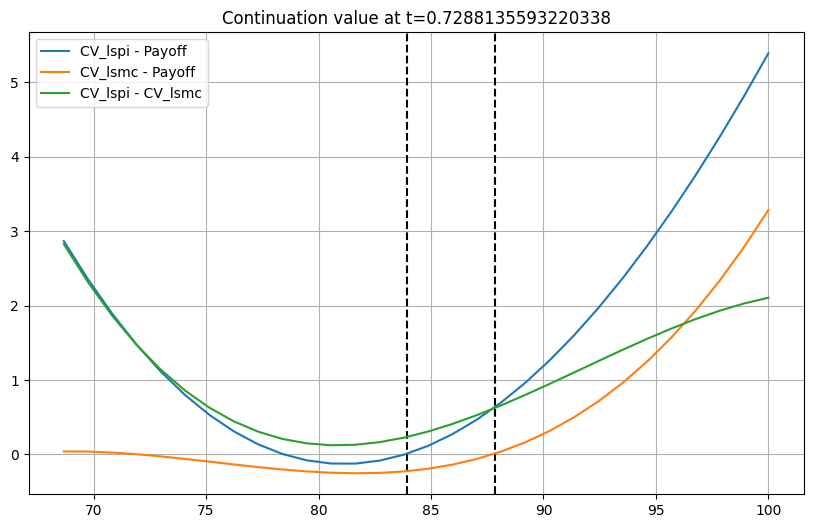

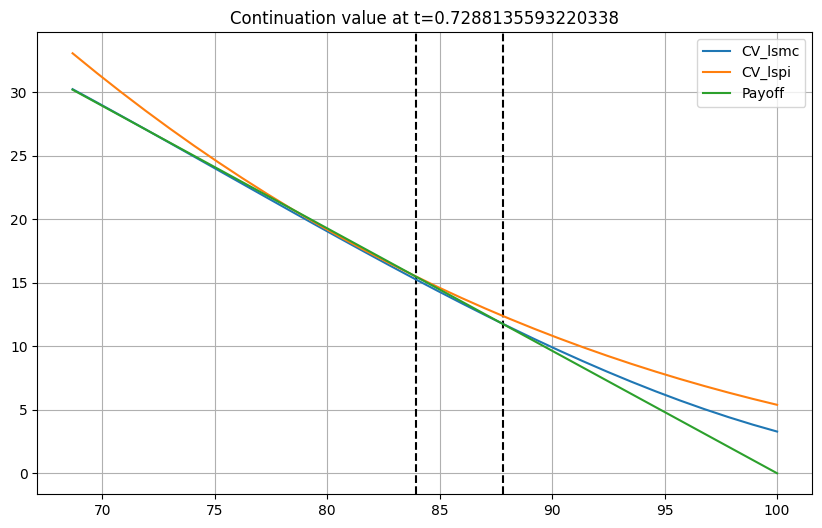

------------------------------------------------------------------------------------------------------------------------


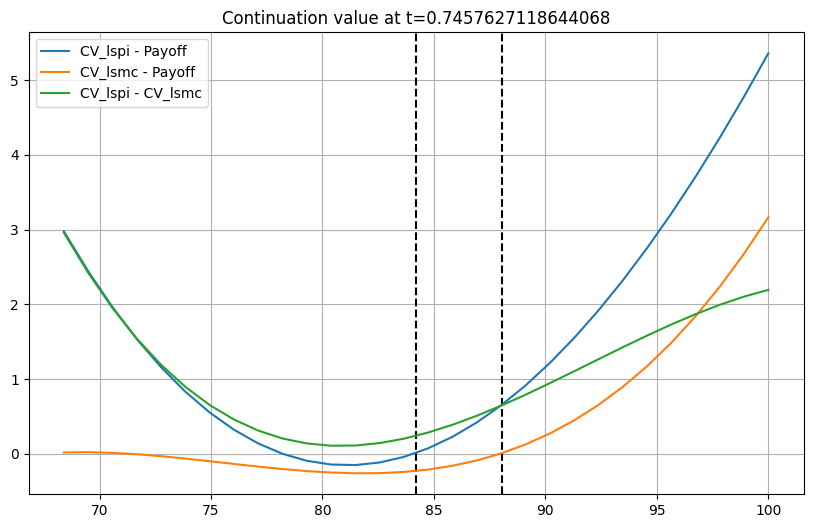

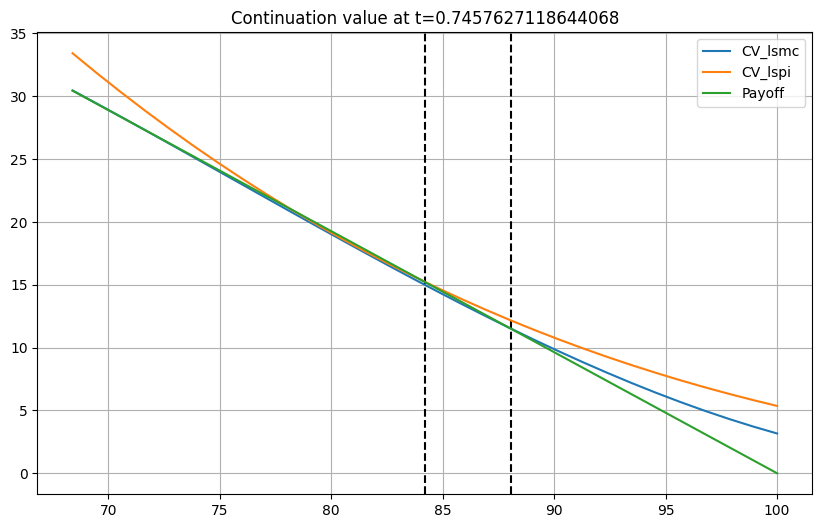

------------------------------------------------------------------------------------------------------------------------


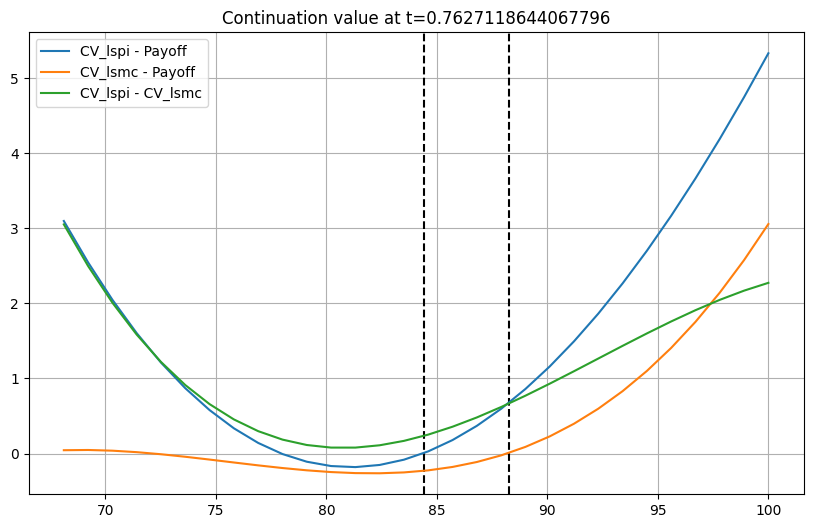

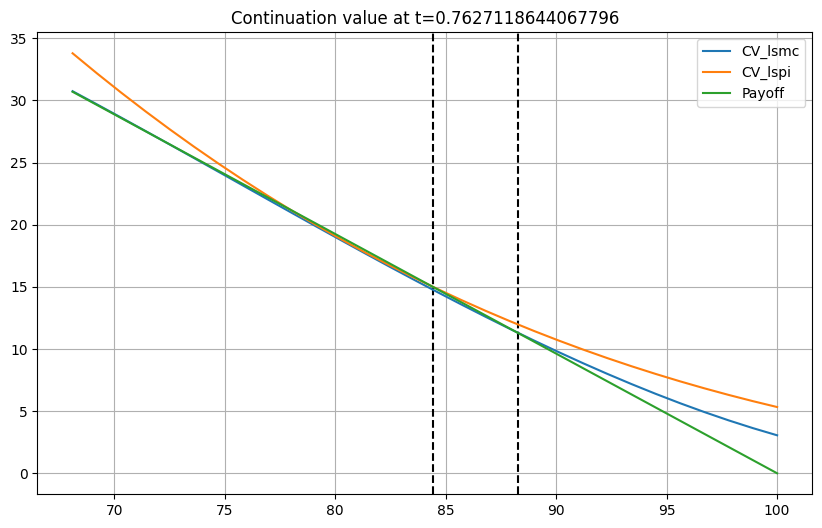

------------------------------------------------------------------------------------------------------------------------


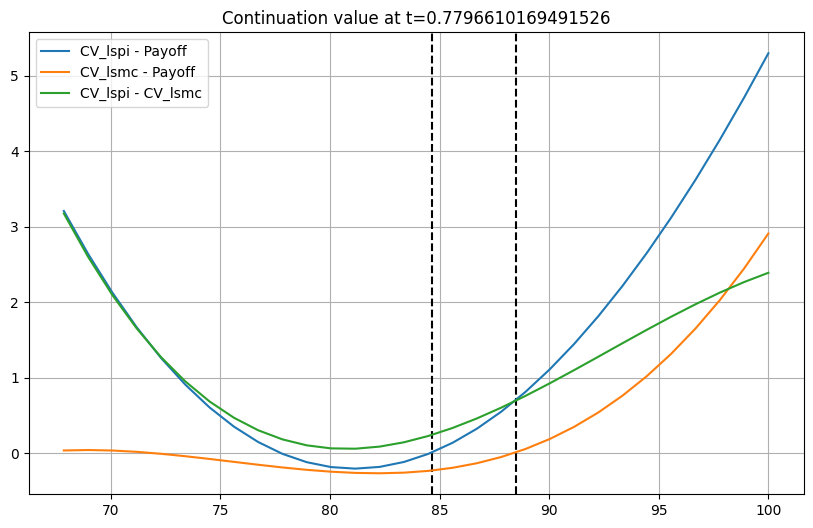

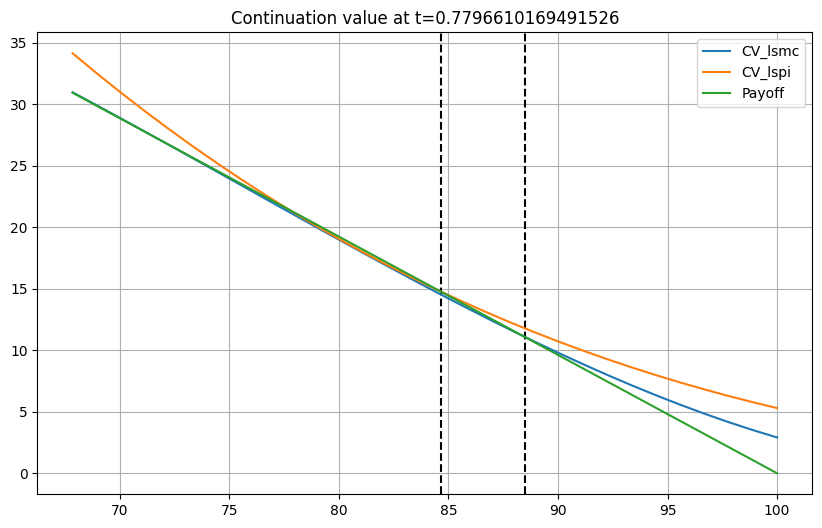

------------------------------------------------------------------------------------------------------------------------


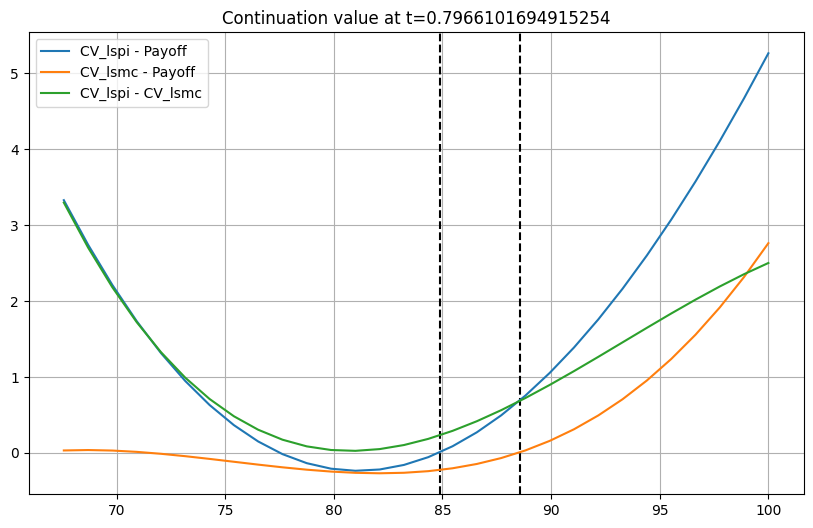

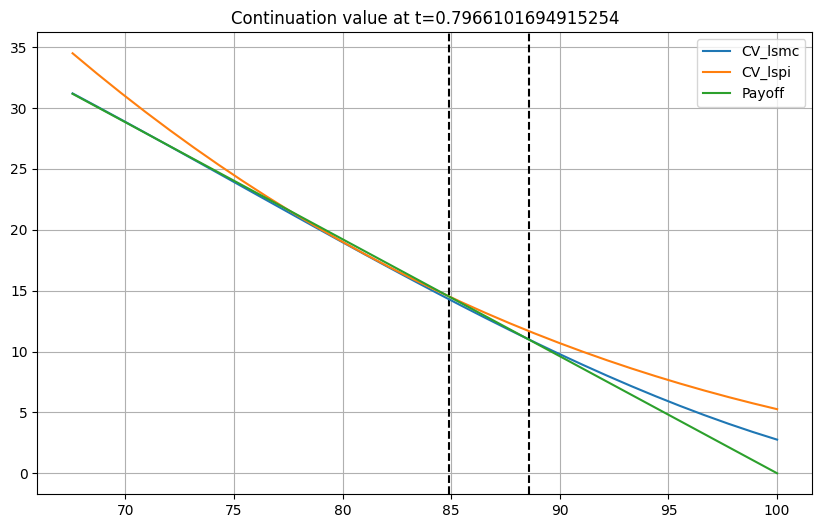

------------------------------------------------------------------------------------------------------------------------


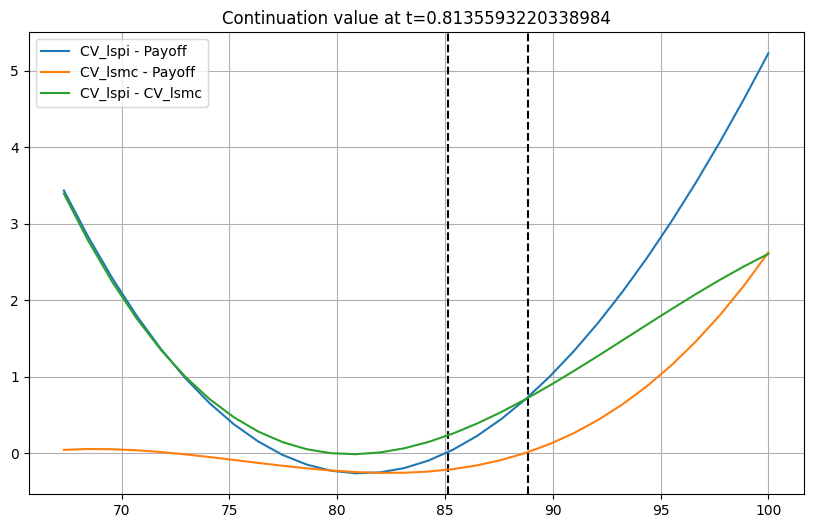

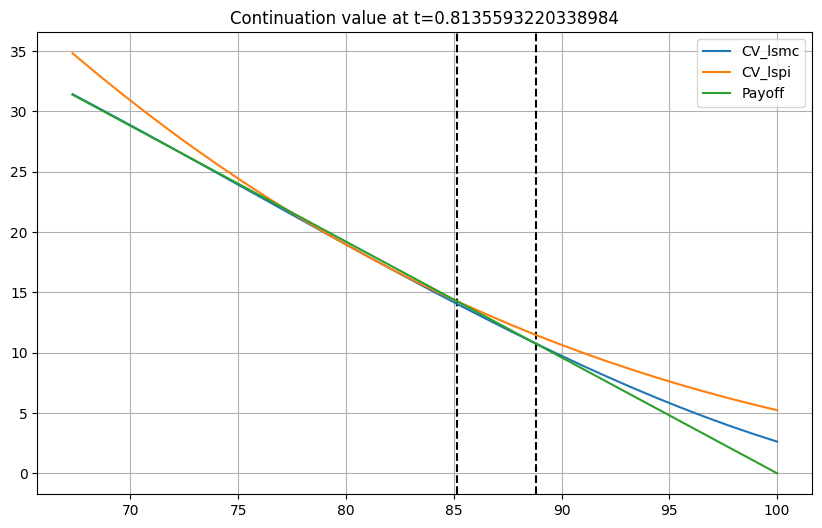

------------------------------------------------------------------------------------------------------------------------


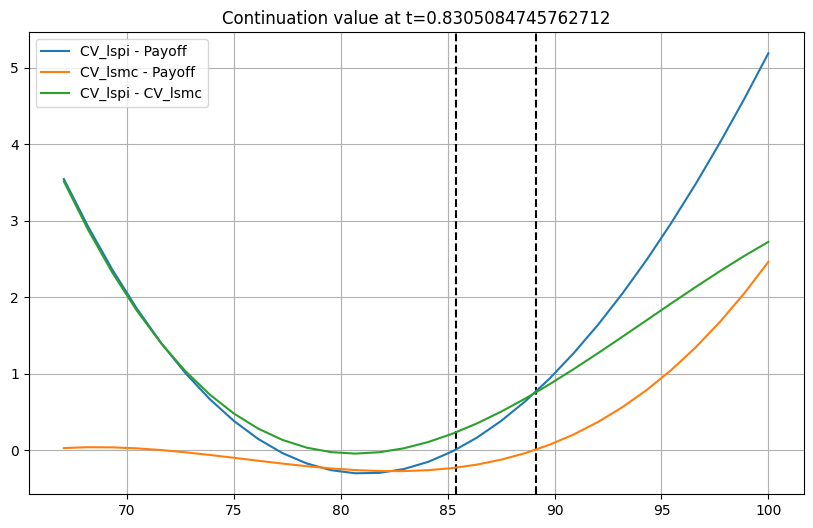

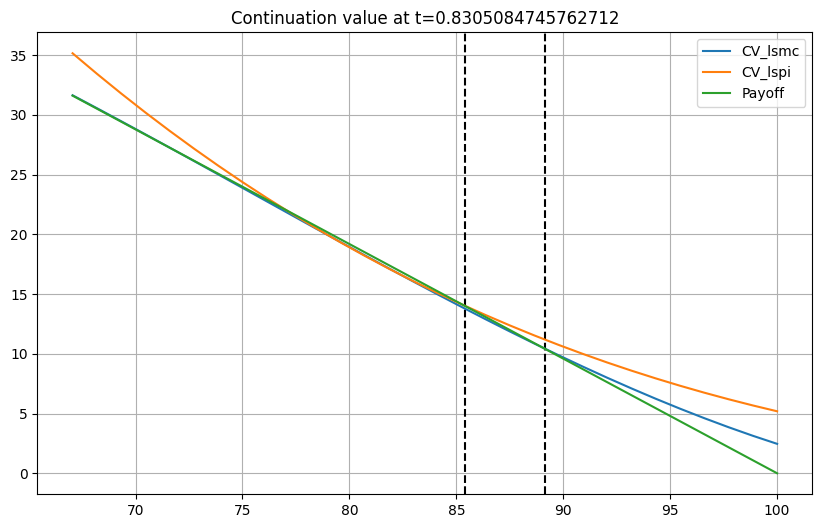

------------------------------------------------------------------------------------------------------------------------


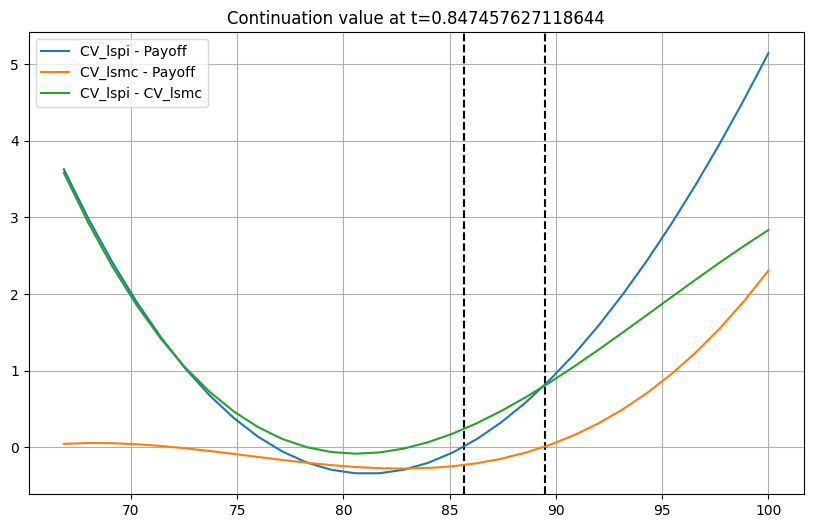

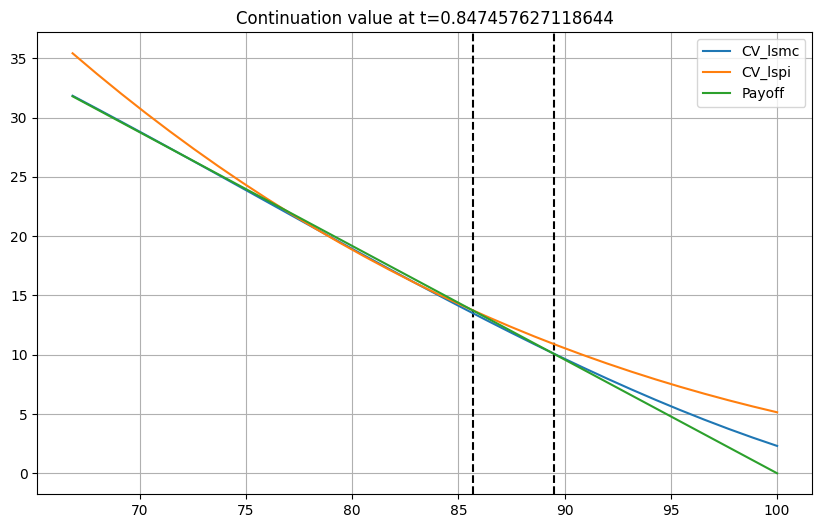

------------------------------------------------------------------------------------------------------------------------


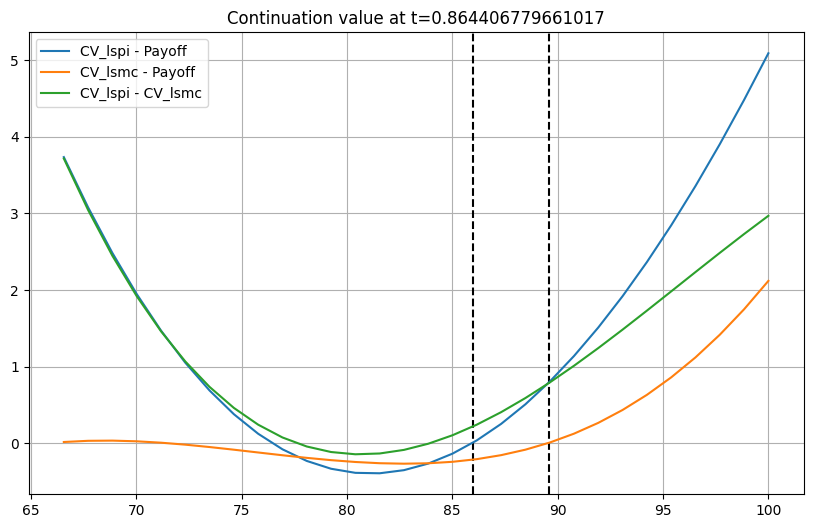

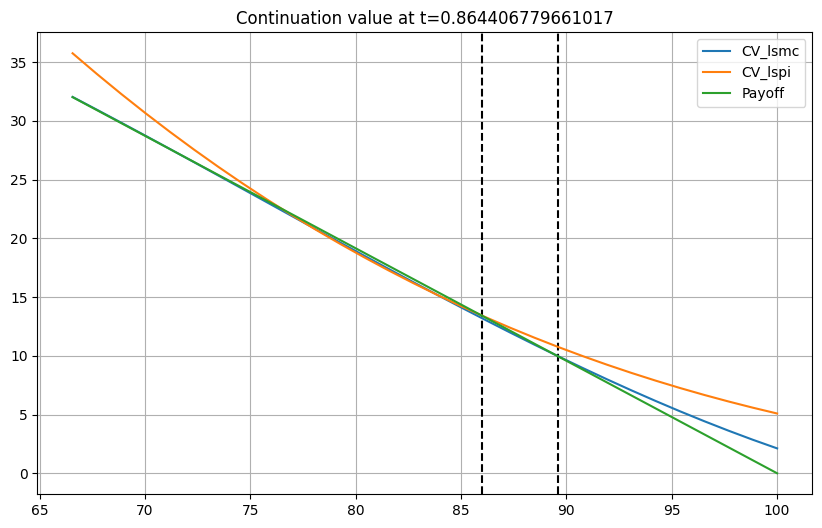

------------------------------------------------------------------------------------------------------------------------


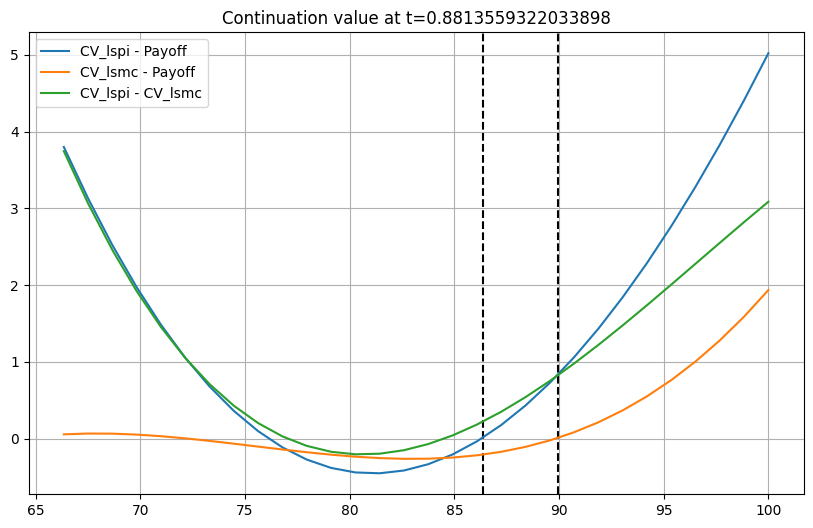

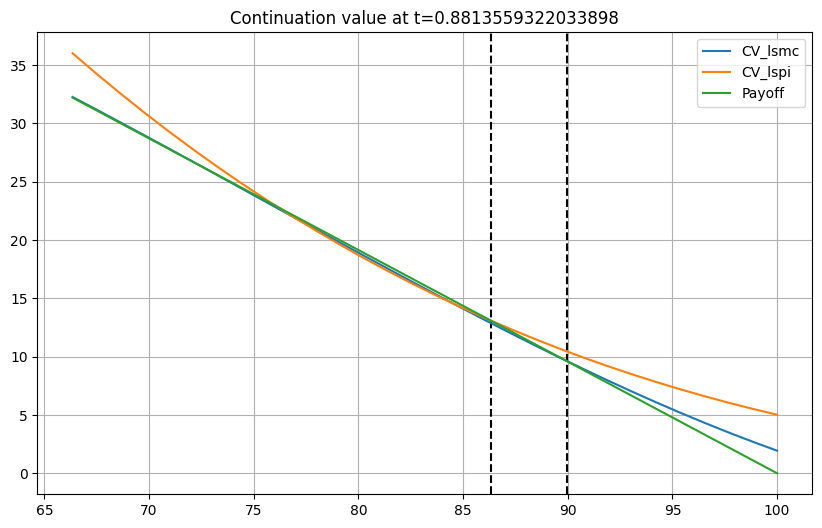

------------------------------------------------------------------------------------------------------------------------


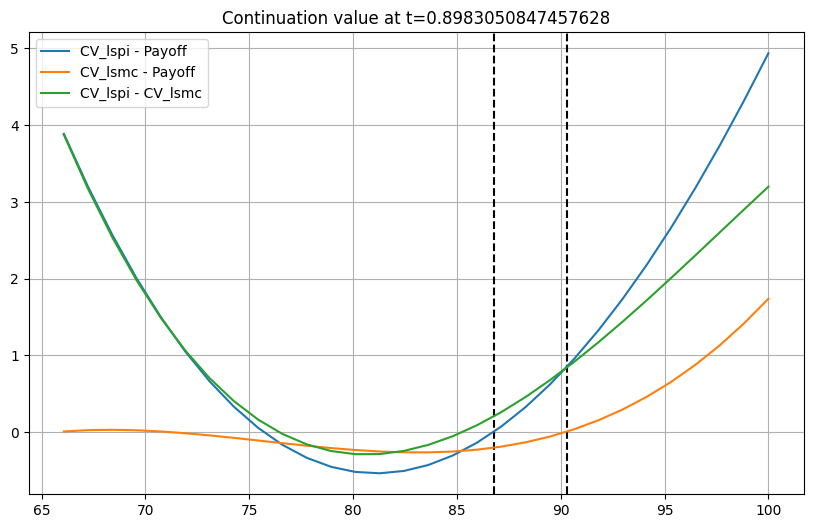

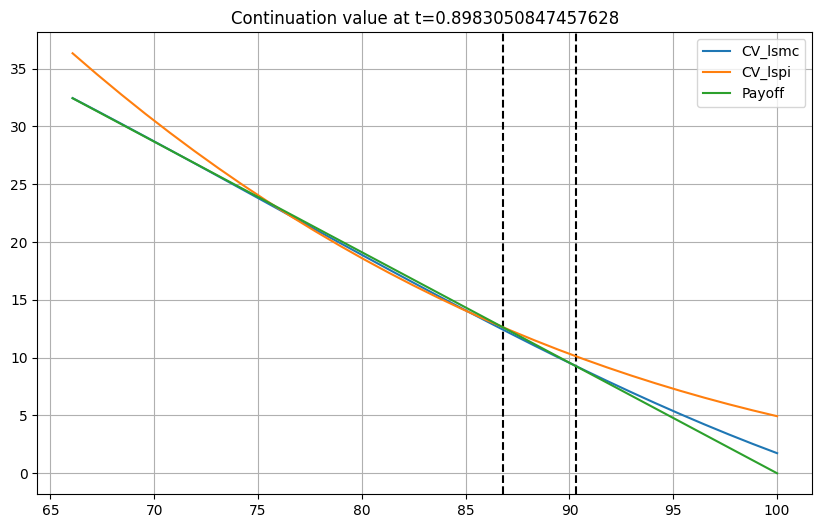

------------------------------------------------------------------------------------------------------------------------


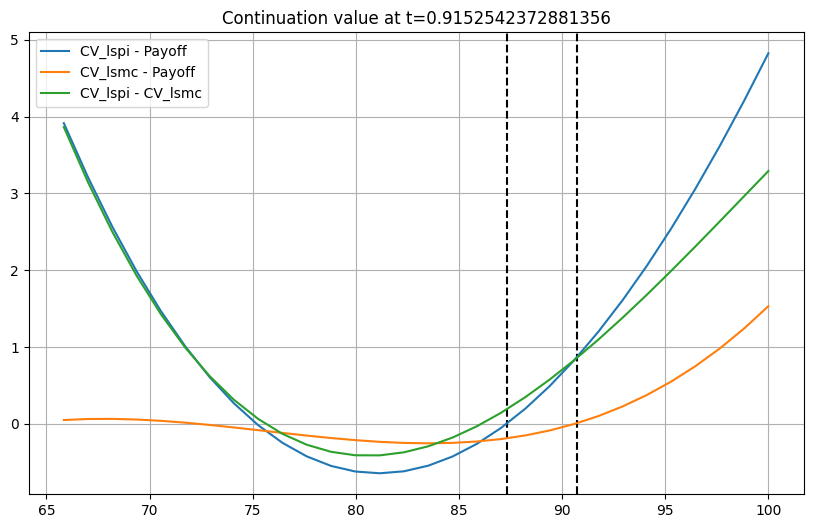

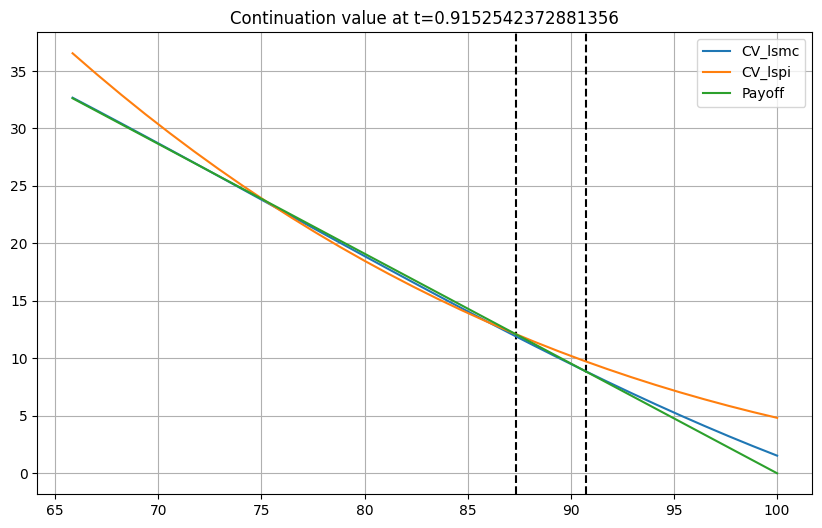

------------------------------------------------------------------------------------------------------------------------


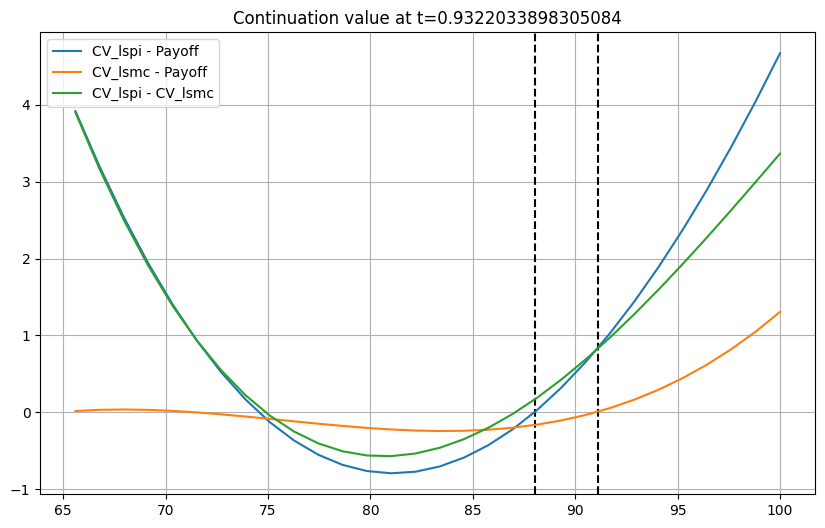

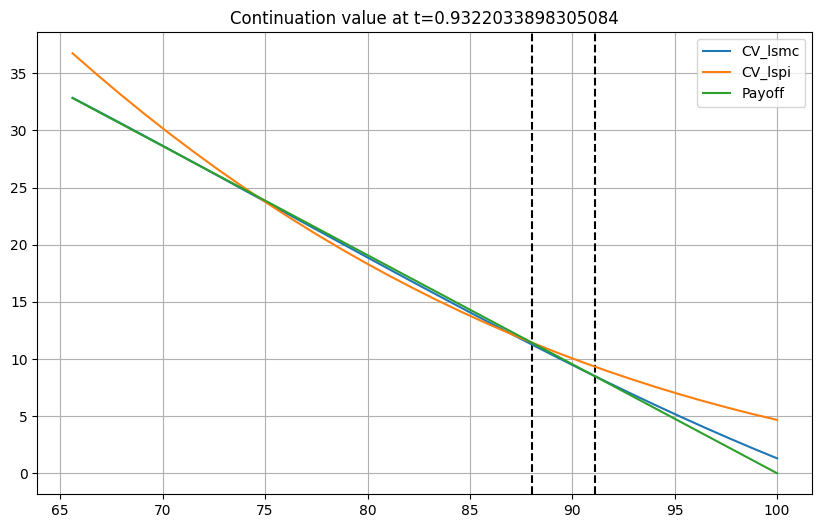

------------------------------------------------------------------------------------------------------------------------


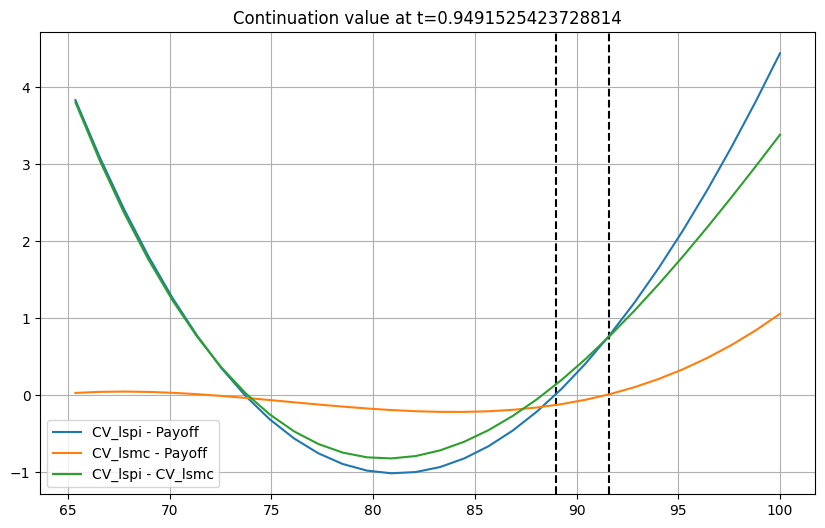

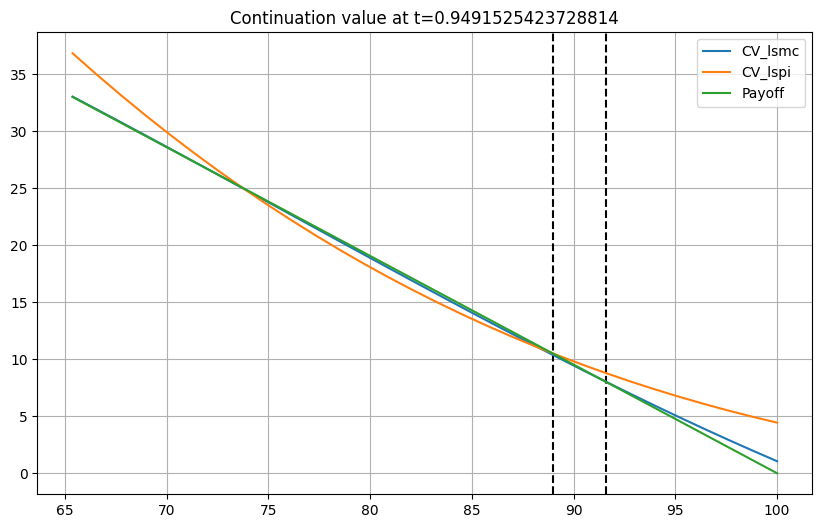

------------------------------------------------------------------------------------------------------------------------


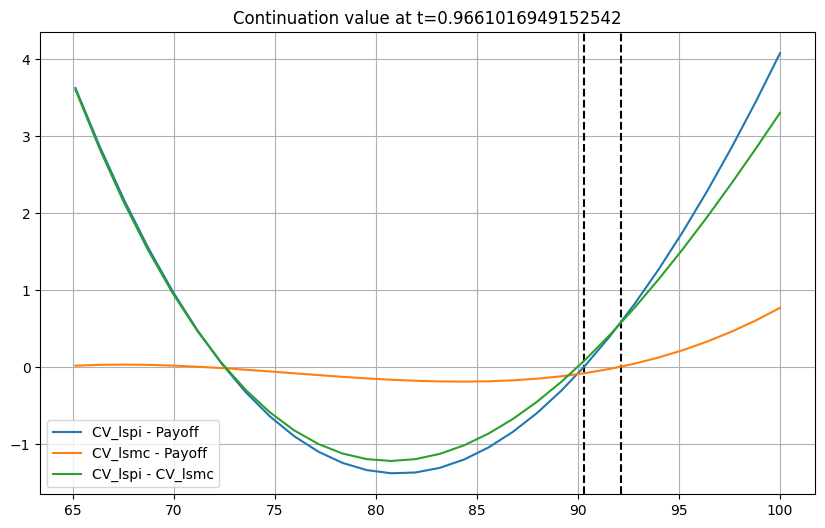

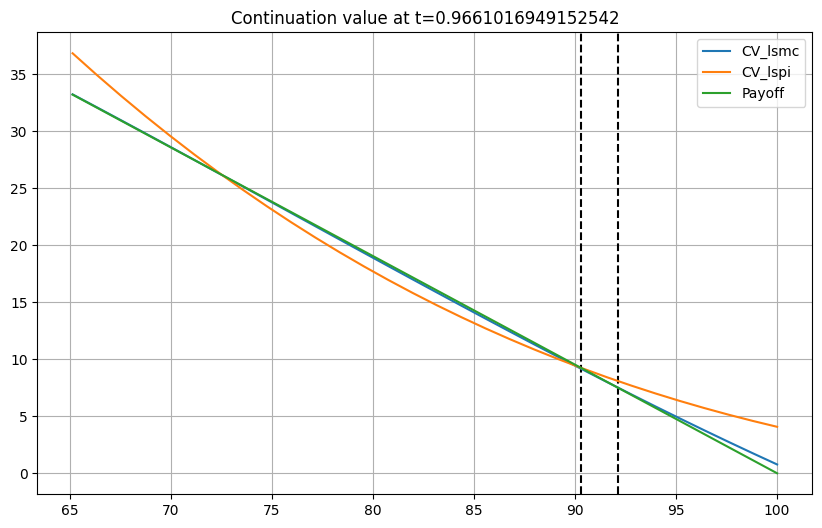

------------------------------------------------------------------------------------------------------------------------


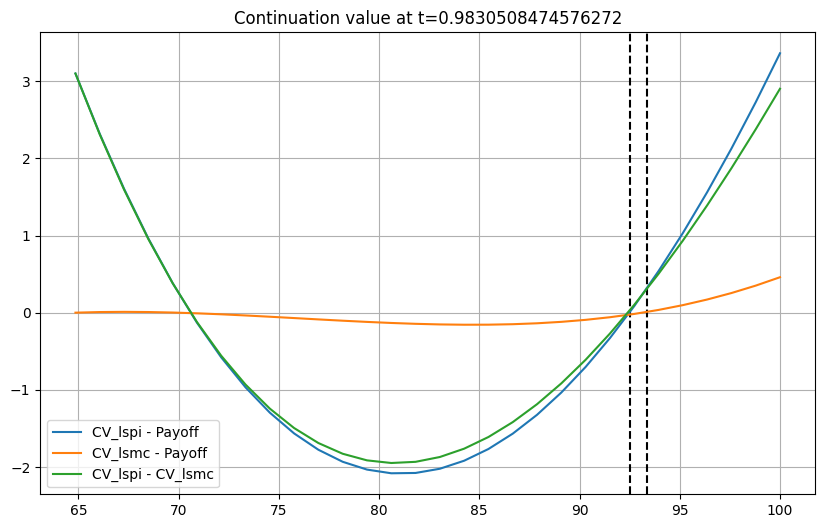

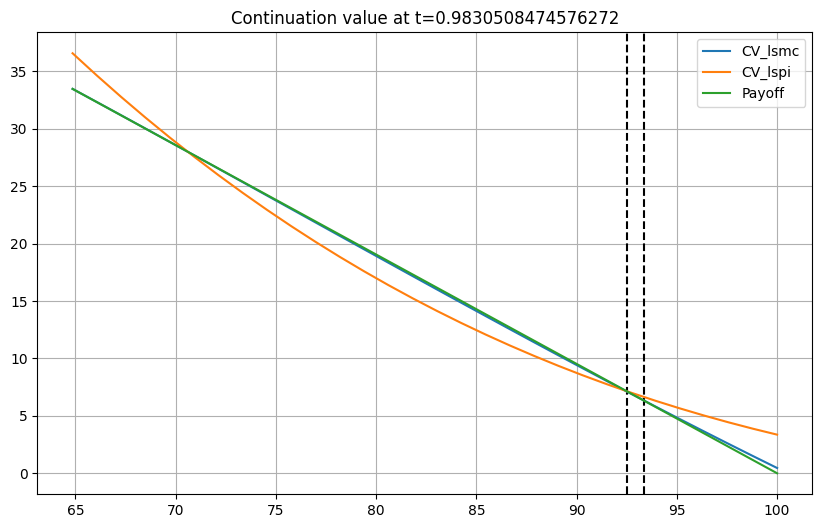

------------------------------------------------------------------------------------------------------------------------


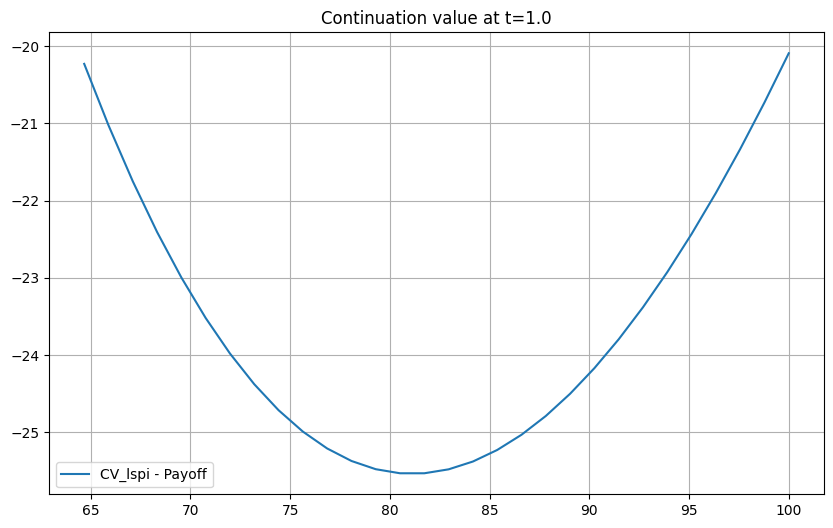

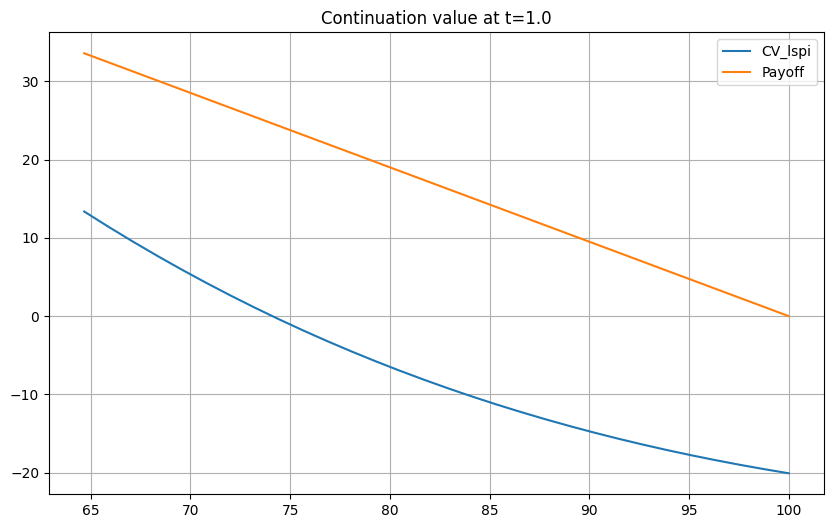

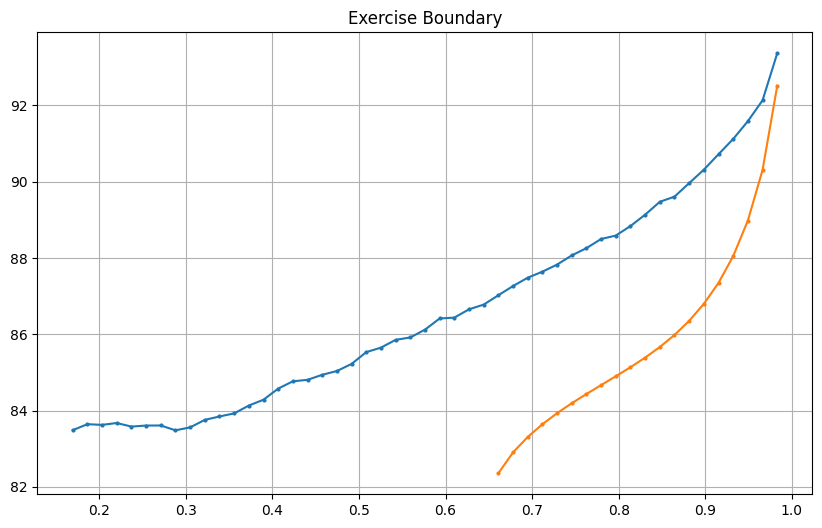

In [12]:
def find_rightmost_root(f, bounds, tol=1e-2, step=1e-3):
    a, b = bounds
    if step is None:
        step = (b - a) / 1000  # Дефолтный шаг — 1/1000 от длины интервала
    
    x = b
    while x >= a:
        if abs(f(x)) < tol:
            return x
        x -= step
    
    # Дополнительная проверка левой границы (если шаг не делит (b - a) точно)
    if abs(f(a)) < tol:
        return a
    
    return None



exercise_boundary_lspi = []
exercise_boundary_lsmc = []

for i, t in tqdm(list(
    enumerate(sampler.time_grid)
)):
    payoff = np.vectorize(
        lambda x:
        sampler.discount_factor[0, i] * max(0, 100. - x)
    )

    continuation_value_lspi =  np.vectorize(
        lambda x:
        _create_features(self, np.array([[[x]]]), np.array([t]))[0, 0] @ self.w * sampler.discount_factor[0, i]
    )

    continuation_value_lsmc = np.vectorize(lambda x: (
        pricer.basis_functions_transformer.transform(
            pricer.scalers[i].transform([[x]])
        ) @ pricer.weights[i]
    ).reshape(-1)[0])

    exercise_boundary_lspi.append(find_rightmost_root(
        lambda x: payoff(x) - continuation_value_lspi(x),
        bounds=[np.percentile(sampler.markov_state[:, i, 0]-1e-6, 0.99), 100]
    ))

    if pricer.weights[i] is not None:
        exercise_boundary_lsmc.append(find_rightmost_root(
            lambda x: payoff(x) - continuation_value_lsmc(x),
            bounds=[np.percentile(sampler.markov_state[:, i, 0]-1e-6, 0.99), 100]
        ))
    else: 
        exercise_boundary_lsmc.append(None)

    print("-"*120)
    plt.figure(figsize=(10, 6))
    plt.title(f"Continuation value at t={t}")
    if exercise_boundary_lspi[-1] is not None:
        plt.axvline(exercise_boundary_lspi[-1], linestyle="--", color="black")
    if exercise_boundary_lsmc[-1] is not None:
        plt.axvline(exercise_boundary_lsmc[-1], linestyle="--", color="black")
    grid = np.linspace(np.percentile(sampler.markov_state[:, i, 0]-1e-6, 0.99), 100, 30)
    plt.plot(grid, continuation_value_lspi(grid) - payoff(grid), label="CV_lspi - Payoff")
    if pricer.weights[i] is not None:
        plt.plot(grid, continuation_value_lsmc(grid) - payoff(grid), label="CV_lsmc - Payoff")
        plt.plot(grid, continuation_value_lspi(grid) - continuation_value_lsmc(grid), label="CV_lspi - CV_lsmc")
    
    plt.title(f"Continuation value at t={t}")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    if exercise_boundary_lspi[-1] is not None:
        plt.axvline(exercise_boundary_lspi[-1], linestyle="--", color="black")
    if exercise_boundary_lsmc[-1] is not None:
        plt.axvline(exercise_boundary_lsmc[-1], linestyle="--", color="black")
    plt.title(f"Continuation value at t={t}")
    grid = np.linspace(np.percentile(sampler.markov_state[:, i, 0]-1e-6, 0.99), 100, 30)
    if pricer.weights[i] is not None:
        plt.plot(grid, continuation_value_lsmc(grid), label="CV_lsmc")
    plt.plot(grid, continuation_value_lspi(grid), label="CV_lspi")
    plt.plot(grid, payoff(grid), label="Payoff")
    plt.legend()
    plt.grid()
    plt.show()

plt.figure(figsize=(10, 6))
plt.title("Exercise Boundary")
plt.plot(sampler.time_grid, exercise_boundary_lsmc, "-o", markersize=2, label="LSMC")
plt.plot(sampler.time_grid, exercise_boundary_lspi, "-o", markersize=2, label="LSPI")
plt.grid()
plt.show()